**Table of contents**<a id='toc0_'></a>    
- [Initial Tests](#toc1_)    
- [Using minimize from scipy.optimize](#toc2_)    
- [Using PyTorch](#toc3_)    
  - [Forward Network](#toc3_1_)    
  - [Inverse Network](#toc3_2_)    
    - [Forward Network --> Inverse Network](#toc3_2_1_)    
    - [Inverse Network --> Forward Network](#toc3_2_2_)    
    - [Only Inverse Network](#toc3_2_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Initial Tests](#toc0_)

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
from ofc_functions import *
from nn_functions import *
import os, glob


In [2]:
# Parameters for the OFC signal
ofc_args = parameters()

ofc_args.SpS = 64            # Samples per symbol 
ofc_args.Rs  = 10e9          # Symbol rate (baud rate - symbols per second)
ofc_args.Ts  = 1/ofc_args.Rs          # Symbol period (s)
ofc_args.Fa  = 1/(ofc_args.Ts/ofc_args.SpS)    # Sampling frequency of the signal (samples per second)
ofc_args.Ta  = 1/ofc_args.Fa          # Sampling period of the signal (s)
ofc_args.NFFT = 16*1024      # Number of points of the FFT 
ofc_args.t = np.arange(0, ofc_args.SpS*500)*ofc_args.Ta # Time vector for the signal (s)
ofc_args.Vpi = 2             # Voltage required to achieve a π phase shift (V)
ofc_args.P = 1              # Amplitude of the laser optical field
ofc_args.n_peaks = 11       # Number of peaks to be found in the signal

# Parameters for the modulators cascaded
mod_args = parameters()
mod_args.V_min = 0 # Minimum amplitude voltage (V)
mod_args.V_max = 3 # Maximum amplitude voltage (V)
mod_args.Phase_min = 0 # Minimum phase (rad)
mod_args.Phase_max = 2*np.pi # Maximum phase (rad) --> Phase is periodic with period 2*π
#mod_args.Phase_max = 10*2*np.pi # Maximum phase (rad)
mod_args.Vb_min = 0 # Minimum bias voltage (V)
mod_args.Vb_max = 4*ofc_args.Vpi # Maximum bias voltage (V) --> Vb is periodic with period 4*Vπ
#args.Vb_max = 10*4*args.Vpi # Maximum bias voltage (V)
mod_args.bounds = [(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max),(mod_args.V_min,mod_args.V_max), 
        (mod_args.Phase_min, mod_args.Phase_max),(mod_args.Phase_min, mod_args.Phase_max), (mod_args.Phase_min, mod_args.Phase_max),
        (mod_args.Vb_min,mod_args.Vb_max), (mod_args.Vb_min,mod_args.Vb_max)] # Bounds of the parameters


In [3]:
def plot_signalPower_and_frequencyComb(V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2):
    
    params = V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2
    frequencyComb = frequencyCombGenerator_MZM_MZM_PM(params, ofc_args.Rs, ofc_args.t, ofc_args.P, ofc_args.Vpi)

    _, ax = plt.subplots(1,3,figsize = (15,3));
    ax[0].plot(ofc_args.t[:ofc_args.SpS*4]*1e9, abs(frequencyComb[:ofc_args.SpS*4])**2, label = "Optical Signal")
    ax[0].set_xlabel("Time (ns)")
    ax[0].set_ylabel("Power (W)")
    ax[0].set_xlim(0,4*ofc_args.Ts*1e9)
    ax[0].set_ylim(0,1)
    ax[0].legend(loc='upper right')
    ax[0].grid()
    
    Pxx, freqs = get_psd_ByFFT(frequencyComb, ofc_args.Fa, ofc_args.NFFT)
    log_Pxx = 10*np.log10(Pxx)
    indx = get_indx_peaks(log_Pxx, ofc_args.NFFT/ofc_args.SpS, ofc_args.n_peaks)

    ax[1].plot(freqs, log_Pxx, label = "Optical Signal Spectrum")
    ax[1].plot(freqs[indx], log_Pxx[indx], 'o')
    ax[1].set_xlim(-20*ofc_args.Rs,20*ofc_args.Rs);
    ax[1].set_ylim(-200,-50);
    ax[1].legend(loc='lower right');
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate");
    ax[1].set_ylabel("Power (dB)");
    ax[1].grid()
    
    mean = np.mean(log_Pxx[indx])
    var = np.var(log_Pxx[indx])
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*mean, "--",label = "peaks mean")
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean+np.sqrt(var)), "--",label = "peaks max")
    ax[1].plot([freqs[0],freqs[-1]], np.array([1,1])*(mean-np.sqrt(var)), "--",label = "peaks min")

    ax[2].axis('off')
    ax[2].text(0, 0.7, "Mean: %.2f dB" %mean, fontsize=10)
    ax[2].text(0, 0.6, "Standard Deviation: %.2f dB" %np.sqrt(var), fontsize=10)
    ax[2].text(0, 0.4, "Variance: %.4f dB^2"%var, fontsize=12)
    ax[2].text(0, 0.3, "max - min: %.4f dB" %(np.max(log_Pxx[indx]) - np.min(log_Pxx[indx])), fontsize=12)

    plt.tight_layout()

In [4]:
import ipywidgets as widgets

initial_values = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06]

V1     = widgets.FloatSlider(value=initial_values[0], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V1')
V2     = widgets.FloatSlider(value=initial_values[1], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V2')
V3     = widgets.FloatSlider(value=initial_values[2], min=mod_args.V_min,     max=mod_args.V_max,    step = 0.001, description = 'V3')
Phase1 = widgets.FloatSlider(value=initial_values[3], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase1')
Phase2 = widgets.FloatSlider(value=initial_values[4], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase2')
Phase3 = widgets.FloatSlider(value=initial_values[5], min=mod_args.Phase_min, max=mod_args.Phase_max,step = 0.001, description = 'Phase3')
Vb1    = widgets.FloatSlider(value=initial_values[6], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb1')
Vb2    = widgets.FloatSlider(value=initial_values[7], min=mod_args.Vb_min,    max=mod_args.Vb_max,   step = 0.001, description = 'Vb2')

ui1 = widgets.HBox([V1, V2, V3, Vb1])
ui2 = widgets.HBox([Phase1, Phase2, Phase3, Vb2])
out1 = widgets.interactive_output(plot_signalPower_and_frequencyComb, {'V1': V1, 'V2': V2,'V3':V3,'Phase1':Phase1, 'Phase2':Phase2, 'Phase3':Phase3,'Vb1': Vb1, 'Vb2': Vb2})

display(ui1, ui2, out1)

Output()

# <a id='toc2_'></a>[Using minimize from scipy.optimize](#toc0_)

In [5]:
# Chute inicial para as configurações dos moduladores (amplitude e fase)
initial_guess = [1.5, 1.5, 1.5, np.pi, np.pi, np.pi, 4, 4]

optimized_params,_, _ = optimization_flatComb(initial_guess, args = ofc_args, bounds = mod_args.bounds)
V1, V2, V3, Phase1, Phase2, Phase3, Vb1, Vb2 = optimized_params

# Exibir as configurações otimizadas
print("Configurações otimizadas:")
print(f"V1: {V1:.4f} V")
print(f"V2: {V2:.4f} V")
print(f"V3: {V3:.4f} V")
print(f"Phase1: {Phase1:.4f} rad")
print(f"Phase2: {Phase2:.4f} rad")
print(f"Phase3: {Phase3:.4f} rad")
print(f"Vb1: {Vb1:.4f} V")
print(f"Vb2: {Vb2:.4f} V")

Configurações otimizadas:
V1: 2.8430 V
V2: 2.5604 V
V3: 2.8924 V
Phase1: 3.6396 rad
Phase2: 3.0298 rad
Phase3: 4.4361 rad
Vb1: 3.9993 V
Vb2: 3.9998 V


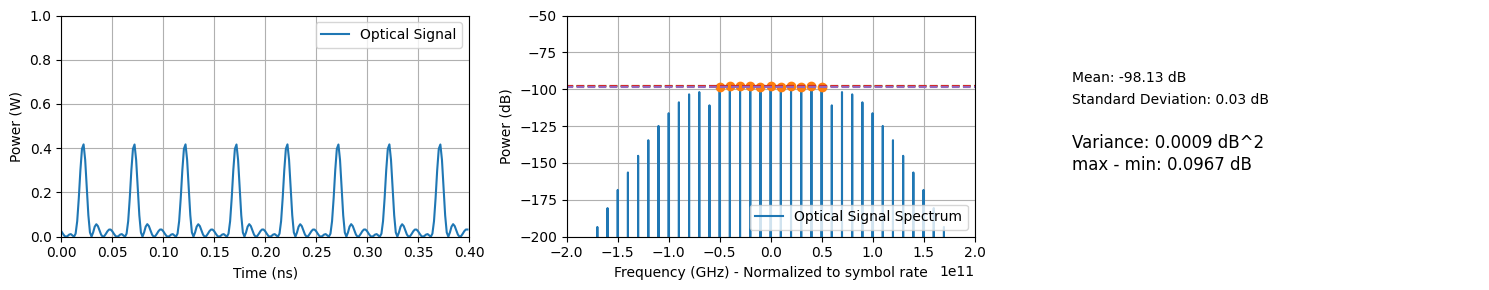

In [6]:
plot_signalPower_and_frequencyComb(*optimized_params)

# <a id='toc3_'></a>[Using PyTorch](#toc0_)

In [7]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.distributions.uniform as urand

In [8]:
class FrequencyCombNet(nn.Module):
    def __init__(self, architecture):
        self.architecture = architecture
        super(FrequencyCombNet, self).__init__()
        layers = [nn.Linear(architecture[0], architecture[1])]
        for i in range(1, len(architecture) - 1):
            layers.append(nn.ReLU())
            layers.append(nn.Linear(architecture[i], architecture[i + 1]))
        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

In [9]:

# Define your custom dataset
class FrequencyCombDataset(Dataset):
    def __init__(self, function, nsamples, ofc_args, bounds, norm_scale = 1):
        self.function = function
        self.nsamples = nsamples
        self.ofc_args = ofc_args
        self.bounds = bounds
        self.norm_scale = norm_scale
        
        inputs = self.make_inputs(self.bounds, self.nsamples)
        self.input_tensors = torch.from_numpy(np.array(inputs)).float()

        outputs = self.make_outputs(inputs, self.function)
        self.output_tensors = torch.from_numpy(np.array(outputs)).float()
        if norm_scale == 1:
            self.norm_scale = torch.ceil(torch.max(torch.abs(self.output_tensors))).item()
        self.output_tensors = self.normalize(self.output_tensors)
    
    def make_inputs(self, bounds, nsamples):
        inputs = [[urand.Uniform(low, high).sample().item() for low, high in bounds] for _ in range(nsamples)]
        return inputs

    def make_outputs(self, inputs, function, zero_mean = True):
        outputs = []
        for input in inputs:
            freq_peaks = function(input, self.ofc_args)
            freq_peaks = freq_peaks - np.mean(freq_peaks)*zero_mean
            outputs.append(freq_peaks)
        return outputs

    def __len__(self):
        return len(self.input_tensors)
    
    def data_size(self):
        inputs_size_in_bytes = self.input_tensors.nelement() * self.input_tensors.element_size()/1024
        outputs_size_in_bytes = self.output_tensors.nelement() * self.output_tensors.element_size()/1024
        return inputs_size_in_bytes + outputs_size_in_bytes
    
    def normalize(self, tensor):
        norm_tensor = (tensor + self.norm_scale) / (2* self.norm_scale)
        return norm_tensor
    
    def denormalize(self, tensor):
        denorm_tensor = tensor * 2* self.norm_scale - self.norm_scale
        return denorm_tensor
    
    def __getitem__(self, idx):
        return self.input_tensors[idx], self.output_tensors[idx]

In [10]:
train_nsamples = 300000           # Number of samples for training   (80%)
val_nspamples  = train_nsamples//8  # Number of samples for validation (10%)
test_nsamples  = train_nsamples//8  # Number of samples for testing    (10%)

#Trying to use CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Runnning in {device}")

Runnning in cuda


In [11]:
#load datasets if they exist, create them otherwise
datasets_folder = "saved_data/datasets/"
dataset_name = f"mzm_mzm_pm_{train_nsamples*1e-3:.0f}k_samples"
train_filename = datasets_folder + "train_dataset_" + dataset_name + ".pt"
test_filename = datasets_folder + "test_dataset_" + dataset_name + ".pt"
val_filename = datasets_folder + "val_dataset_" + dataset_name + ".pt"
if os.path.exists(train_filename) and os.path.exists(test_filename) and os.path.exists(val_filename):
    print("Loading datasets...")
    train_dataset = torch.load(train_filename)
    test_dataset = torch.load(test_filename)
    val_dataset = torch.load(val_filename)
    print("Datasets loaded!")
else:
    print("Creating datasets...")
    train_dataset = FrequencyCombDataset(frequencyCombPeaks, train_nsamples, ofc_args = ofc_args, bounds = mod_args.bounds)
    test_dataset  = FrequencyCombDataset(frequencyCombPeaks, test_nsamples,  ofc_args = ofc_args, bounds = mod_args.bounds, norm_scale=train_dataset.norm_scale)
    val_dataset   = FrequencyCombDataset(frequencyCombPeaks, val_nspamples,  ofc_args = ofc_args, bounds = mod_args.bounds, norm_scale=train_dataset.norm_scale)
    print("Datasets created!")

    torch.save(train_dataset, train_filename)
    torch.save(test_dataset, test_filename)
    torch.save(val_dataset, val_filename)
    print("Datasets saved!")


Loading datasets...
Datasets loaded!


In [12]:
max_flat_samples = 35000

files = glob.glob(datasets_folder+'flatComb_*')
if len(files) > 0:
    print("Loading flatComb datasets...")
    flatComb_inputs0_1dB = np.load(glob.glob(datasets_folder + "flatComb_inputs0_1dB_*")[0])
    flatComb_outputs0_1dB = np.load(glob.glob(datasets_folder + "flatComb_outputs0_1dB_*")[0])

    flatComb_inputs1_5dB = np.load(glob.glob(datasets_folder + "flatComb_inputs1_5dB_*")[0])
    flatComb_outputs1_5dB = np.load(glob.glob(datasets_folder + "flatComb_outputs1_5dB_*")[0])

    for file in files:
        print(file) 
    print("FlatComb datasets loaded!")

else:
    print("Creating flatComb datasets...")
    flatComb_inputs0_1dB, flatComb_outputs0_1dB, flatComb_inputs1_5dB, flatComb_outputs1_5dB = create_flatCombs(max_flat_samples, args = ofc_args, bounds = mod_args.bounds)

    #save flatComb_inputs and flatComb_outputs
    np.save(datasets_folder + f"flatComb_inputs0_1dB_{len(flatComb_inputs0_1dB)}.npy", flatComb_inputs0_1dB)
    np.save(datasets_folder + f"flatComb_outputs0_1dB_{len(flatComb_outputs0_1dB)}.npy", flatComb_outputs0_1dB)

    np.save(datasets_folder + f"flatComb_inputs1_5dB_{len(flatComb_inputs1_5dB)}.npy", flatComb_inputs1_5dB)
    np.save(datasets_folder + f"flatComb_outputs1_5dB_{len(flatComb_outputs1_5dB)}.npy", flatComb_outputs1_5dB)

    print("FlatComb datasets created and saved!")

Loading flatComb datasets...
saved_data/datasets\flatComb_inputs0_1dB_17055.npy
saved_data/datasets\flatComb_inputs1_5dB_14491.npy
saved_data/datasets\flatComb_outputs0_1dB_17055.npy
saved_data/datasets\flatComb_outputs1_5dB_14491.npy
FlatComb datasets loaded!


In [13]:
#normalization
flatComb_outputs0_1dB = train_dataset.normalize(flatComb_outputs0_1dB)
flatComb_outputs1_5dB = train_dataset.normalize(flatComb_outputs1_5dB)

#split the flatComb data into train, test and validation
train_flatComb_inputs0_1dB, train_flatComb_outputs0_1dB, val_flatComb_inputs0_1dB, val_flatComb_outputs0_1dB, test_flatComb_inputs0_1dB, test_flatComb_outputs0_1dB = split_train_val_test_data(flatComb_inputs0_1dB, flatComb_outputs0_1dB, shuffle = True)
train_flatComb_inputs1_5dB, train_flatComb_outputs1_5dB, val_flatComb_inputs1_5dB, val_flatComb_outputs1_5dB, test_flatComb_inputs1_5dB, test_flatComb_outputs1_5dB = split_train_val_test_data(flatComb_inputs1_5dB, flatComb_outputs1_5dB, shuffle = True)

In [14]:
#add the flatCombs (0-1dB) and combs 1-5dB data to the big datasets

train_dataset.input_tensors = torch.cat((train_dataset.input_tensors, torch.from_numpy(train_flatComb_inputs0_1dB).float(), torch.from_numpy(train_flatComb_inputs1_5dB).float()))
train_dataset.output_tensors = torch.cat((train_dataset.output_tensors, torch.from_numpy(train_flatComb_outputs0_1dB).float(), torch.from_numpy(train_flatComb_outputs1_5dB).float()))

val_dataset.input_tensors = torch.cat((val_dataset.input_tensors, torch.from_numpy(val_flatComb_inputs0_1dB).float(), torch.from_numpy(val_flatComb_inputs1_5dB).float()))
val_dataset.output_tensors = torch.cat((val_dataset.output_tensors, torch.from_numpy(val_flatComb_outputs0_1dB).float(), torch.from_numpy(val_flatComb_outputs1_5dB).float()))

test_dataset.input_tensors = torch.cat((test_dataset.input_tensors, torch.from_numpy(test_flatComb_inputs0_1dB).float(), torch.from_numpy(test_flatComb_inputs1_5dB).float()))
test_dataset.output_tensors = torch.cat((test_dataset.output_tensors, torch.from_numpy(test_flatComb_outputs0_1dB).float(), torch.from_numpy(test_flatComb_outputs1_5dB).float()))

In [19]:
count1=0
for i in range(len(train_dataset.output_tensors)):
    min_max = np.max(train_dataset.denormalize(train_dataset.output_tensors[i]).numpy()) - np.min(train_dataset.denormalize(train_dataset.output_tensors[i]).numpy())
    if min_max < 1:
        count1+=1
        
print(f"Porcentagem do dataset que é flat comb: {count1/len(train_dataset.output_tensors)*100:.2f}%")

Porcentagem do dataset que é flat comb: 4.20%


In [20]:
# Create data loaders
batch_size = 1024
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=True)

In [148]:
# Initialize the model
n_inputs = train_dataset.input_tensors.shape[1]
n_outputs = train_dataset.output_tensors.shape[1]
architecture = [n_inputs, 200, 290, 290, 200, n_outputs]
#architecture = [n_inputs, 256, 256, 256, 256, n_outputs]

model = FrequencyCombNet(architecture).to(device)
model_name = "model_" + "_".join([f"{n:.0f}" for n in architecture]) + "_" + dataset_name + "_batch_size_" + f"{batch_size:.0f}"
model_path = "saved_data/models/"+ model_name +".pth"

# load model
if os.path.exists(model_path):
    print("Loading model...")
    model.load_state_dict(torch.load(model_path))
    model.eval()
    print("Model loaded!")
else:
    print("No model found!")
    print("Model created!")

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # lr - learning rate

No model found!
Model created!


In [150]:
calc_num_params(architecture)

204891

In [151]:
# Training loop

## losses
train_losses_path = "saved_data/losses/" + model_name + '_train_losses.npy'
val_losses_path = "saved_data/losses/" + model_name + '_val_losses.npy'

# Load training losses if file exists
if os.path.exists(train_losses_path) and os.path.exists(val_losses_path):
    train_losses = list(np.load(train_losses_path))
    val_losses = list(np.load(val_losses_path))
    print("Losses files loaded!")
else:
    print("Losses files not found.")
    train_losses, val_losses = [], []
    print("Losses files created!")

Losses files not found.
Losses files created!


## <a id='toc3_1_'></a>[Forward Network](#toc0_)

Validation loss decreased (1.000000 --> 0.000708). Epoch: 1. Saving model...
Validation loss decreased (0.000708 --> 0.000688). Epoch: 2. Saving model...
Validation loss decreased (0.000688 --> 0.000623). Epoch: 3. Saving model...
Validation loss decreased (0.000623 --> 0.000604). Epoch: 5. Saving model...
Validation loss decreased (0.000604 --> 0.000596). Epoch: 8. Saving model...
Validation loss decreased (0.000596 --> 0.000582). Epoch: 9. Saving model...
Validation loss decreased (0.000582 --> 0.000572). Epoch: 11. Saving model...
Validation loss decreased (0.000572 --> 0.000565). Epoch: 12. Saving model...
Validation loss decreased (0.000565 --> 0.000558). Epoch: 13. Saving model...
Validation loss decreased (0.000558 --> 0.000537). Epoch: 15. Saving model...
Validation loss decreased (0.000537 --> 0.000534). Epoch: 17. Saving model...
Validation loss decreased (0.000534 --> 0.000512). Epoch: 19. Saving model...
Epoch: 20/200.. Training loss: 18.965336 (dB/Hz)^2.. Validation Loss: 

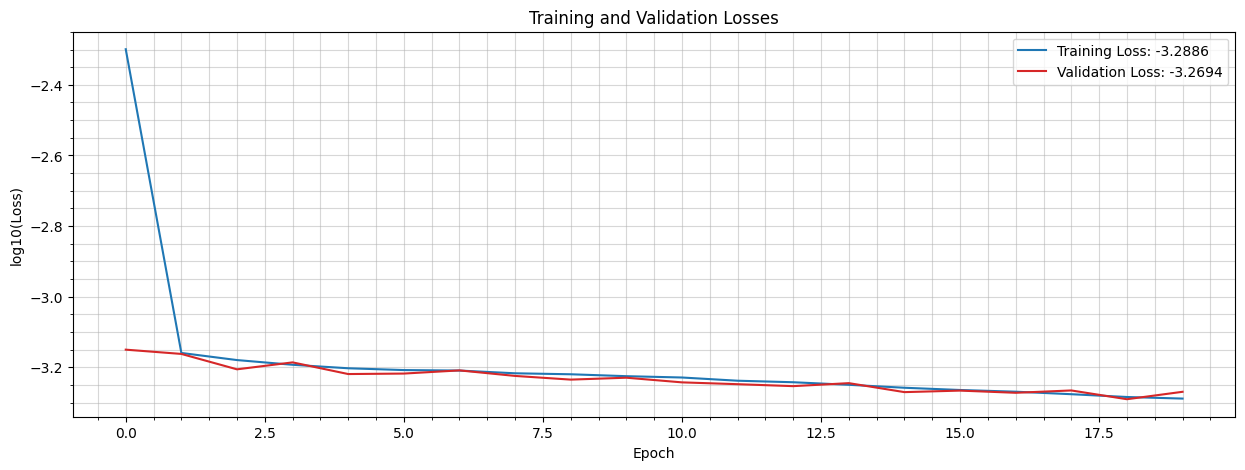

Validation loss decreased (0.000512 --> 0.000502). Epoch: 21. Saving model...
Validation loss decreased (0.000502 --> 0.000501). Epoch: 22. Saving model...
Validation loss decreased (0.000501 --> 0.000478). Epoch: 24. Saving model...
Validation loss decreased (0.000478 --> 0.000478). Epoch: 25. Saving model...
Validation loss decreased (0.000478 --> 0.000472). Epoch: 26. Saving model...
Validation loss decreased (0.000472 --> 0.000463). Epoch: 27. Saving model...
Validation loss decreased (0.000463 --> 0.000462). Epoch: 28. Saving model...
Validation loss decreased (0.000462 --> 0.000444). Epoch: 30. Saving model...
Validation loss decreased (0.000444 --> 0.000427). Epoch: 32. Saving model...
Validation loss decreased (0.000427 --> 0.000411). Epoch: 34. Saving model...
Validation loss decreased (0.000411 --> 0.000403). Epoch: 35. Saving model...
Validation loss decreased (0.000403 --> 0.000396). Epoch: 36. Saving model...
Validation loss decreased (0.000396 --> 0.000392). Epoch: 37. Sa

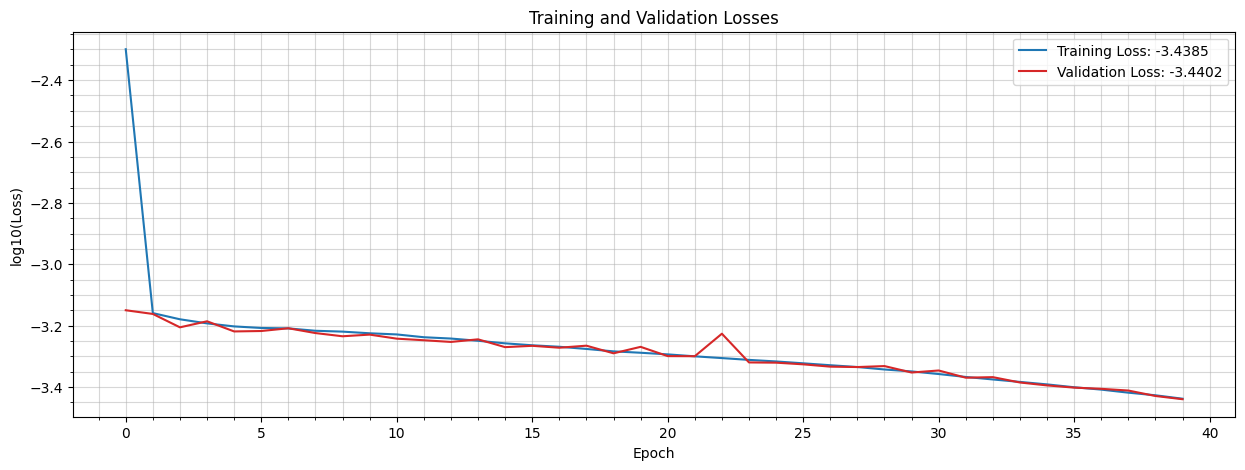

Validation loss decreased (0.000372 --> 0.000363). Epoch: 40. Saving model...
Validation loss decreased (0.000363 --> 0.000357). Epoch: 41. Saving model...
Validation loss decreased (0.000357 --> 0.000354). Epoch: 42. Saving model...
Validation loss decreased (0.000354 --> 0.000350). Epoch: 43. Saving model...
Validation loss decreased (0.000350 --> 0.000334). Epoch: 44. Saving model...
Validation loss decreased (0.000334 --> 0.000327). Epoch: 45. Saving model...
Validation loss decreased (0.000327 --> 0.000321). Epoch: 47. Saving model...
Validation loss decreased (0.000321 --> 0.000308). Epoch: 48. Saving model...
Validation loss decreased (0.000308 --> 0.000300). Epoch: 50. Saving model...
Validation loss decreased (0.000300 --> 0.000296). Epoch: 51. Saving model...
Validation loss decreased (0.000296 --> 0.000294). Epoch: 52. Saving model...
Validation loss decreased (0.000294 --> 0.000288). Epoch: 53. Saving model...
Validation loss decreased (0.000288 --> 0.000280). Epoch: 54. Sa

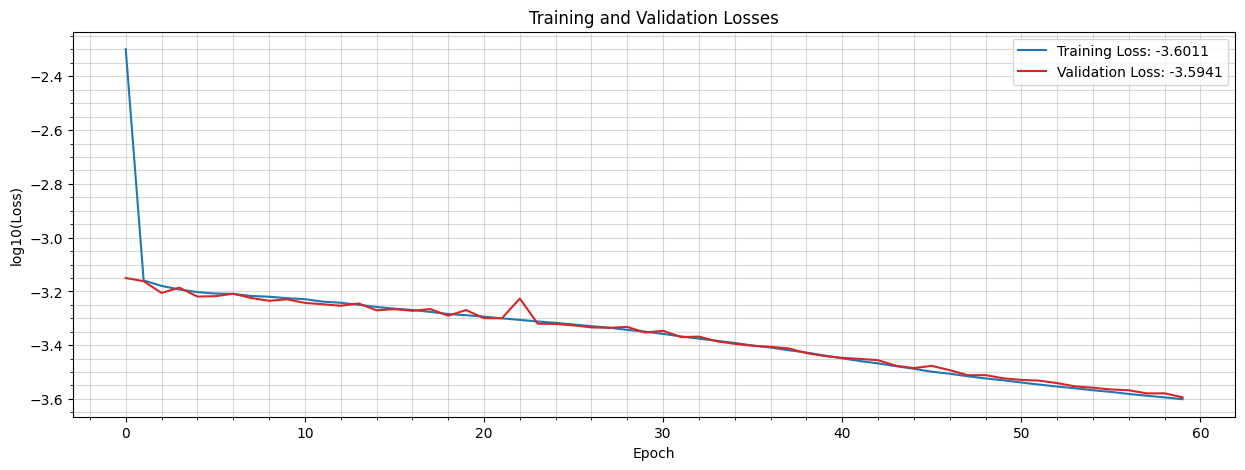

Validation loss decreased (0.000263 --> 0.000255). Epoch: 60. Saving model...
Validation loss decreased (0.000255 --> 0.000251). Epoch: 61. Saving model...
Validation loss decreased (0.000251 --> 0.000248). Epoch: 62. Saving model...
Validation loss decreased (0.000248 --> 0.000247). Epoch: 63. Saving model...
Validation loss decreased (0.000247 --> 0.000242). Epoch: 64. Saving model...
Validation loss decreased (0.000242 --> 0.000240). Epoch: 67. Saving model...
Validation loss decreased (0.000240 --> 0.000231). Epoch: 68. Saving model...
Validation loss decreased (0.000231 --> 0.000230). Epoch: 70. Saving model...
Validation loss decreased (0.000230 --> 0.000228). Epoch: 71. Saving model...
Validation loss decreased (0.000228 --> 0.000227). Epoch: 72. Saving model...
Validation loss decreased (0.000227 --> 0.000221). Epoch: 73. Saving model...
Validation loss decreased (0.000221 --> 0.000220). Epoch: 75. Saving model...
Validation loss decreased (0.000220 --> 0.000216). Epoch: 76. Sa

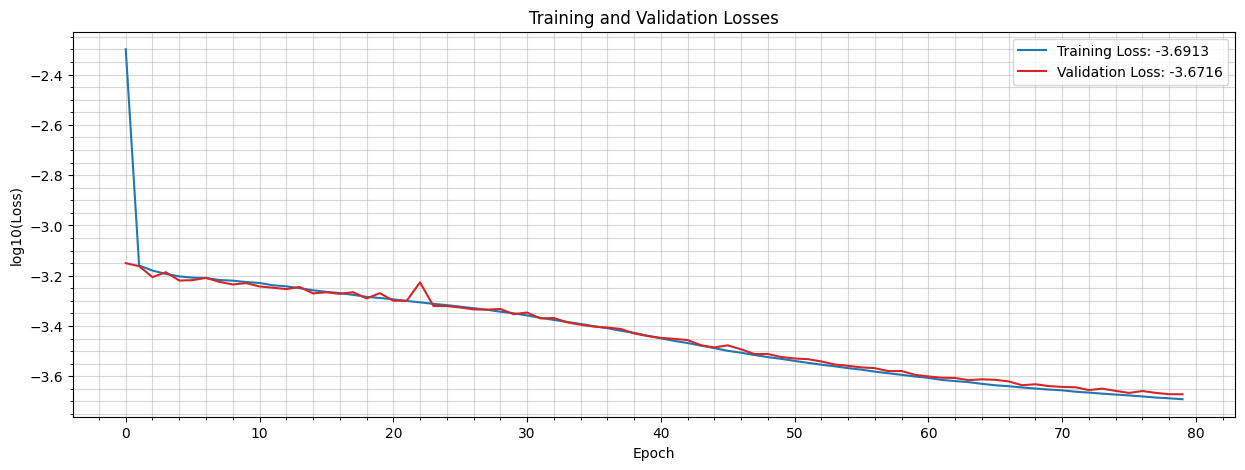

Validation loss decreased (0.000213 --> 0.000213). Epoch: 80. Saving model...
Validation loss decreased (0.000213 --> 0.000209). Epoch: 81. Saving model...
Validation loss decreased (0.000209 --> 0.000207). Epoch: 83. Saving model...
Validation loss decreased (0.000207 --> 0.000205). Epoch: 84. Saving model...
Validation loss decreased (0.000205 --> 0.000203). Epoch: 85. Saving model...
Validation loss decreased (0.000203 --> 0.000200). Epoch: 88. Saving model...
Validation loss decreased (0.000200 --> 0.000198). Epoch: 90. Saving model...
Validation loss decreased (0.000198 --> 0.000197). Epoch: 91. Saving model...
Validation loss decreased (0.000197 --> 0.000195). Epoch: 92. Saving model...
Validation loss decreased (0.000195 --> 0.000193). Epoch: 95. Saving model...
Validation loss decreased (0.000193 --> 0.000192). Epoch: 96. Saving model...
Validation loss decreased (0.000192 --> 0.000192). Epoch: 97. Saving model...
Validation loss decreased (0.000192 --> 0.000191). Epoch: 98. Sa

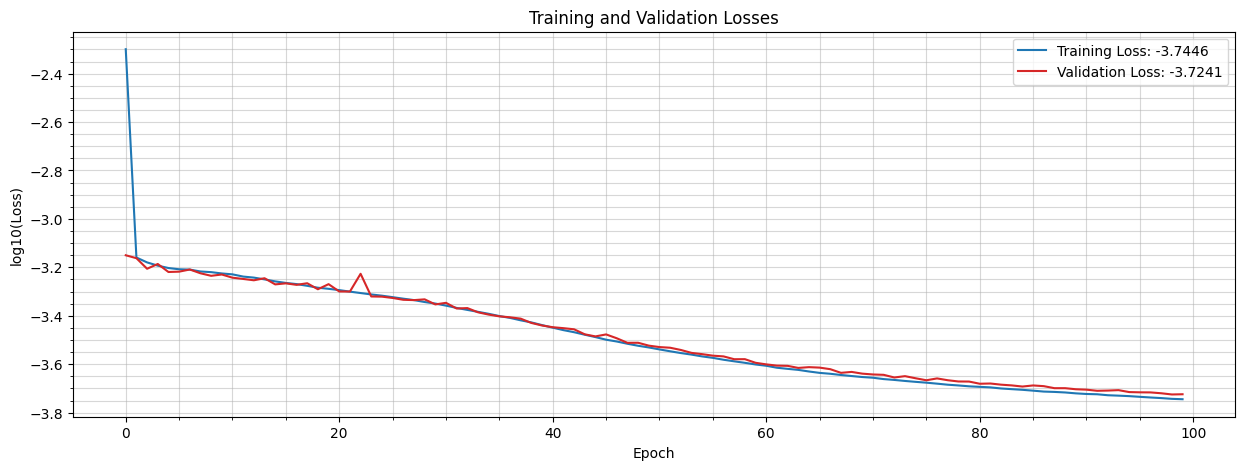

Validation loss decreased (0.000188 --> 0.000187). Epoch: 101. Saving model...
Validation loss decreased (0.000187 --> 0.000187). Epoch: 102. Saving model...
Validation loss decreased (0.000187 --> 0.000184). Epoch: 103. Saving model...


In [152]:
num_epochs = 200
val_loss_min = 1
 
for epoch in range(1, num_epochs + 1):

    # Training phase
    model.train() # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass
        outputs = model(inputs) # Calculate outputs (forward pass)
        loss = criterion(outputs, targets) # Calculate loss

        # Backward pass
        loss.backward() # Calculate gradients
        optimizer.step() # Update weights

        running_loss += loss.item() * inputs.size(0) # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset) # Calculate average loss over an epoch
    train_losses.append(avg_train_loss) #Epoch training losses for plotting

    # Validation phase
    model.eval() # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss) # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {convert_to_real_loss(train_losses[-1], train_dataset.norm_scale):.6f} (dB/Hz)^2.. Validation Loss: {convert_to_real_loss(val_losses[-1], train_dataset.norm_scale):.6f} (dB/Hz)^2")
        #plot_training_progress(real_train_losses, real_val_losses, ylabel = "Loss (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    #'''
    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(model.state_dict(), model_name + "val_min.pth")
        val_loss_min = avg_val_loss
    #'''

In [133]:
# Save model
torch.save(model.state_dict(), model_path)

# Save training and validation losses
np.save(train_losses_path, np.array(train_losses))
np.save(val_losses_path, np.array(val_losses))


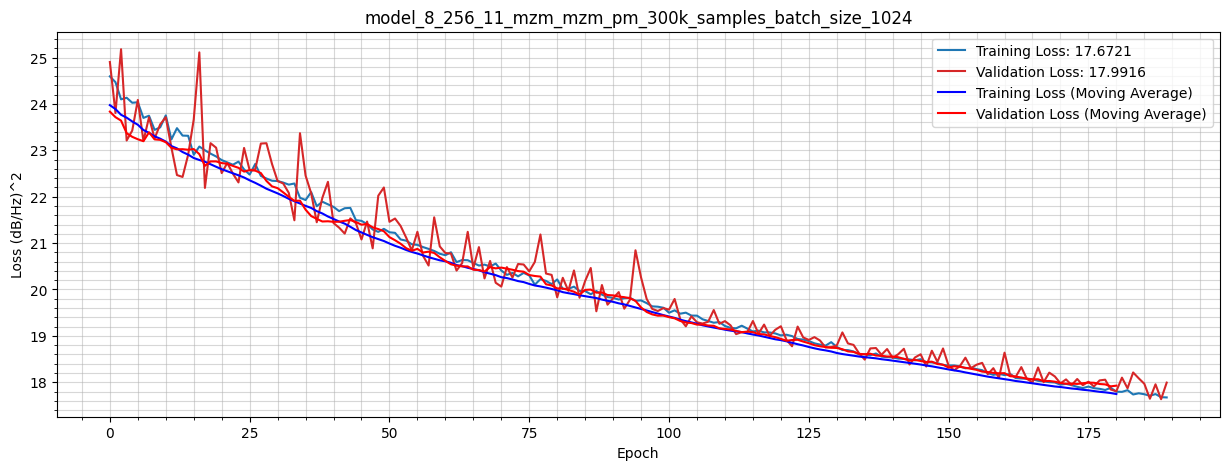

In [96]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

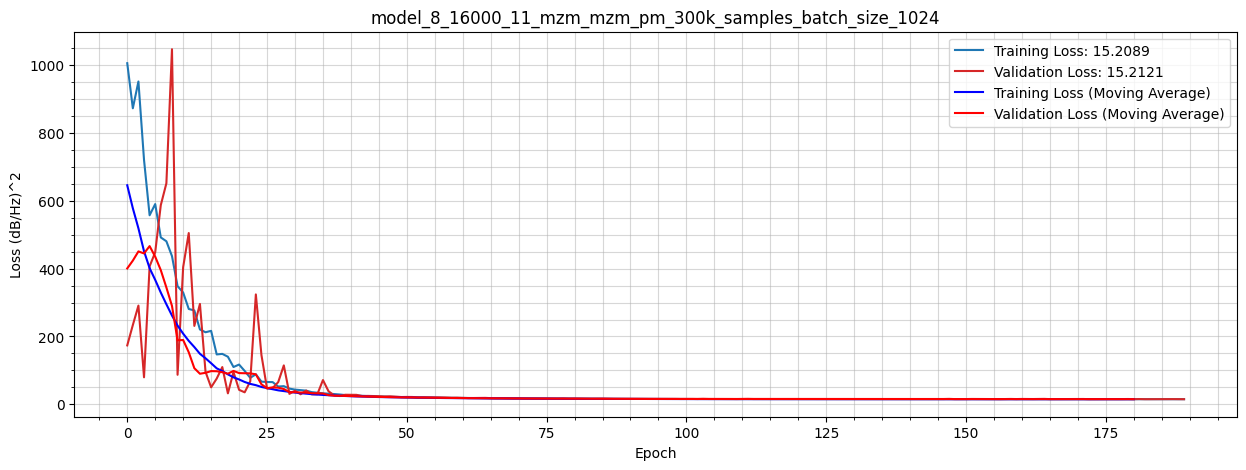

In [107]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

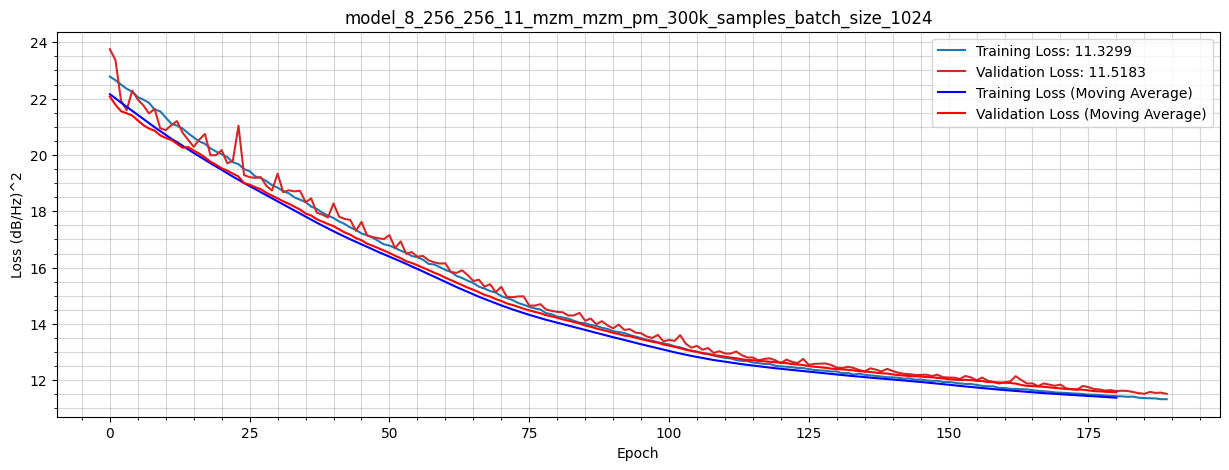

In [118]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

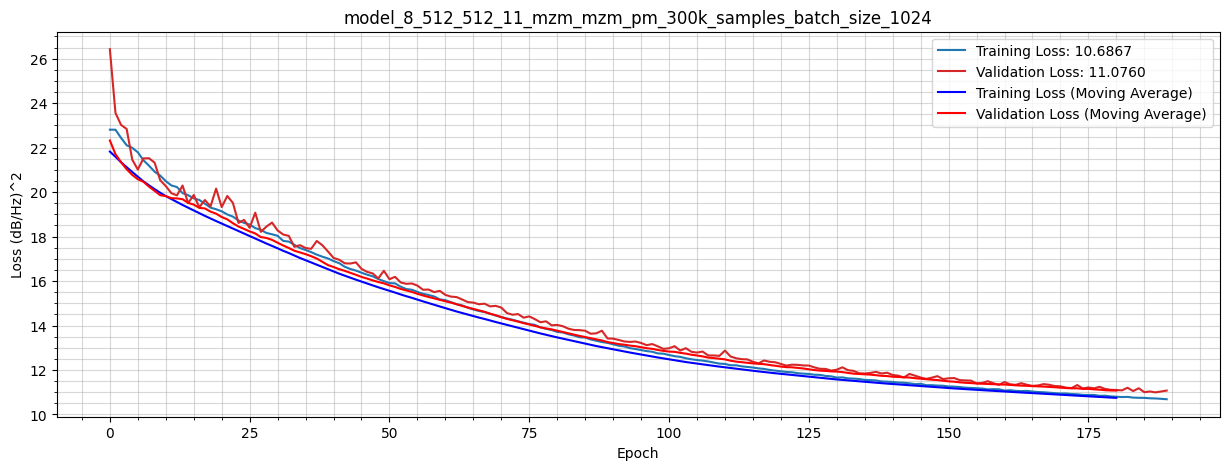

In [30]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

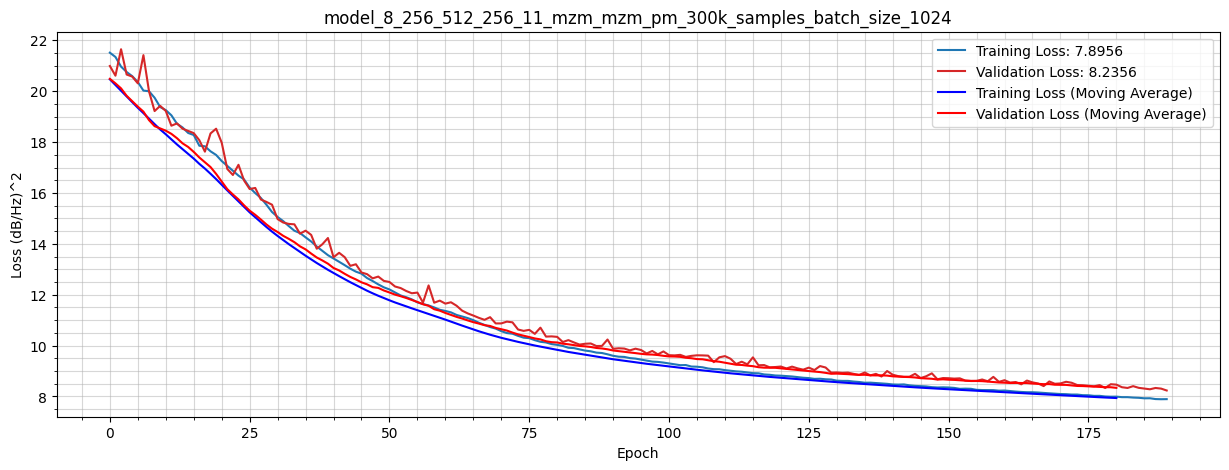

In [95]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

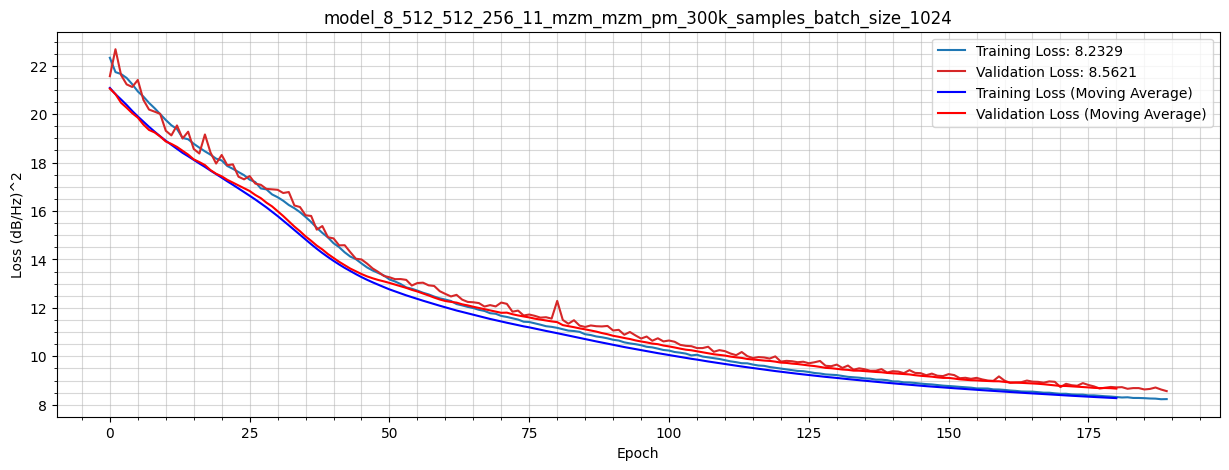

In [102]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

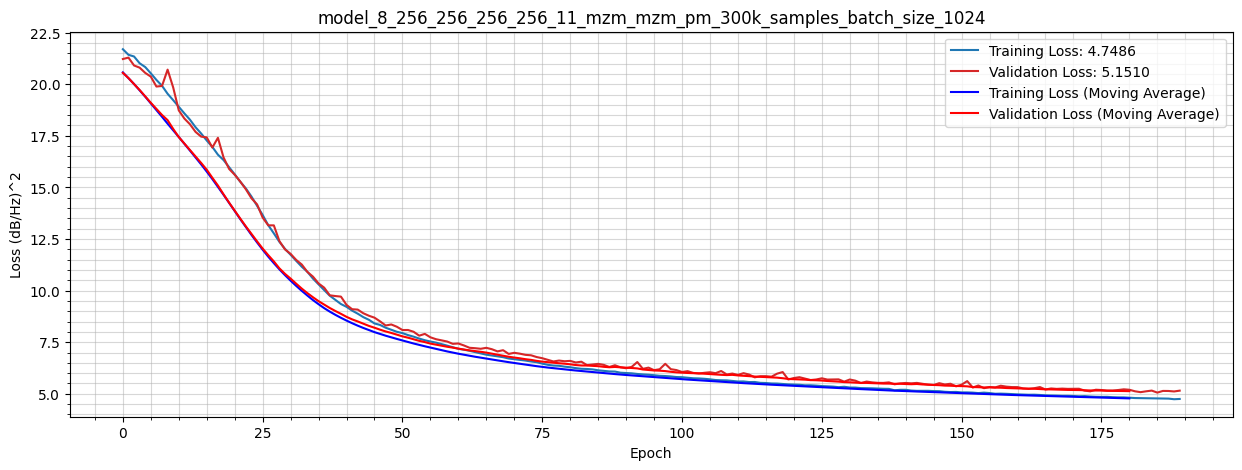

In [114]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

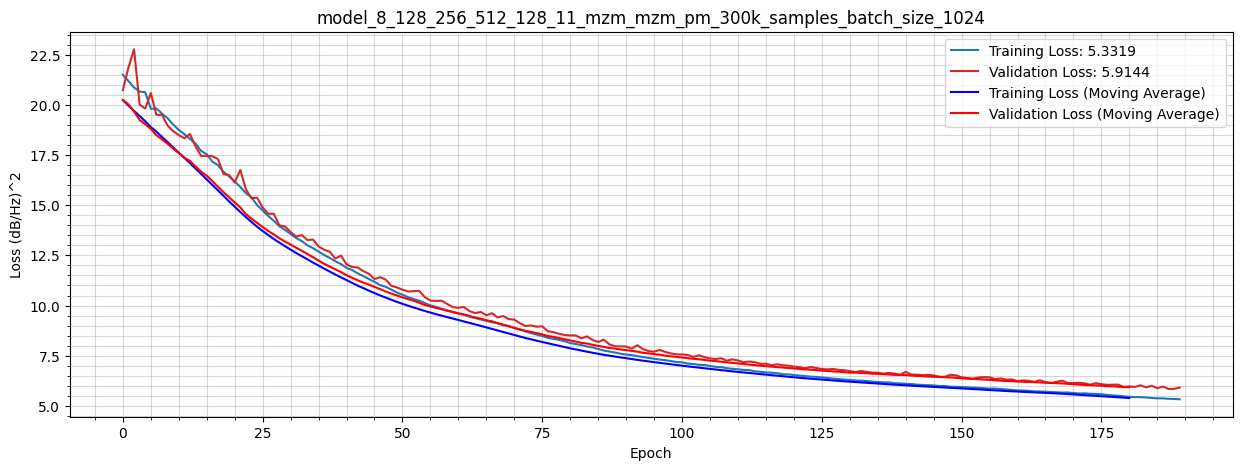

In [134]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

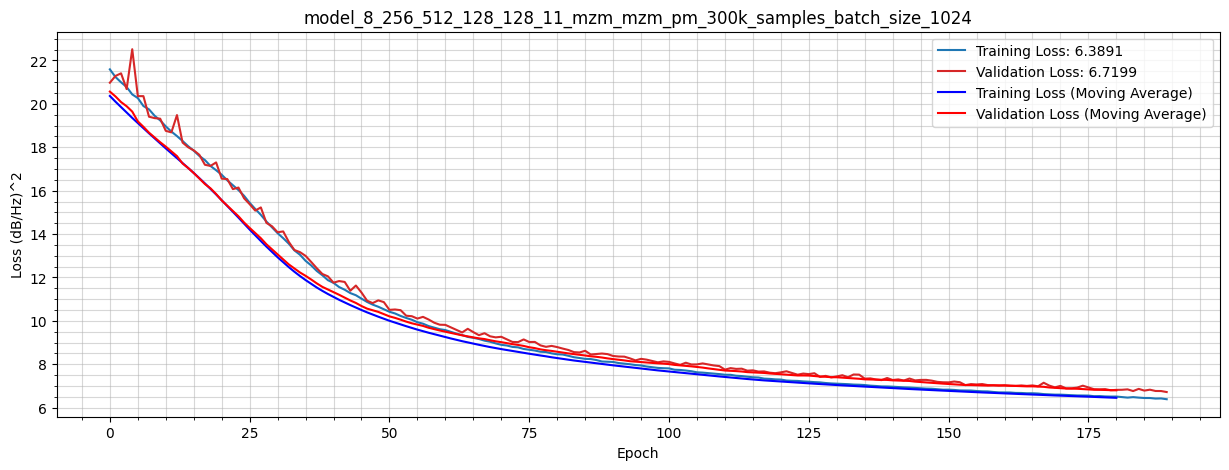

In [143]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

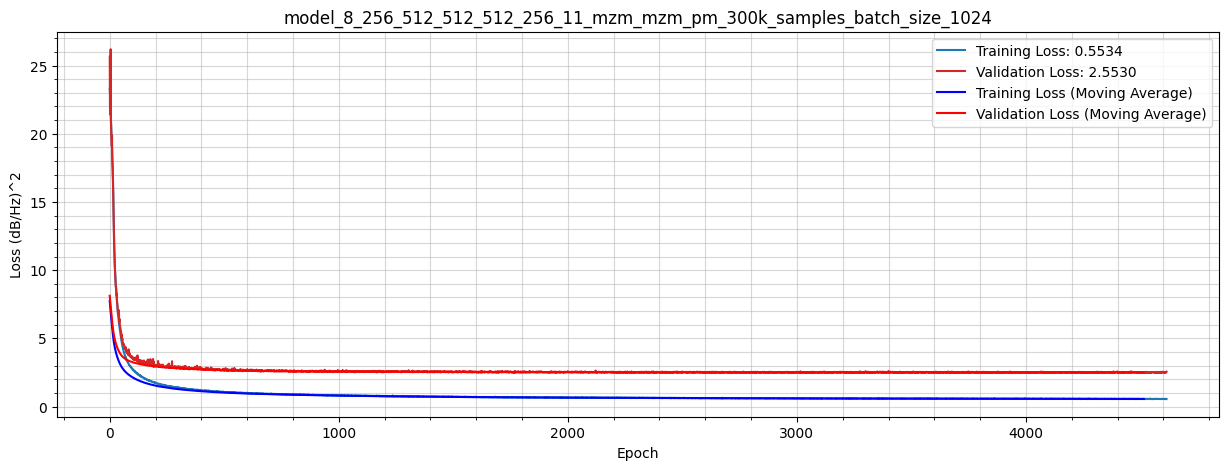

In [37]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

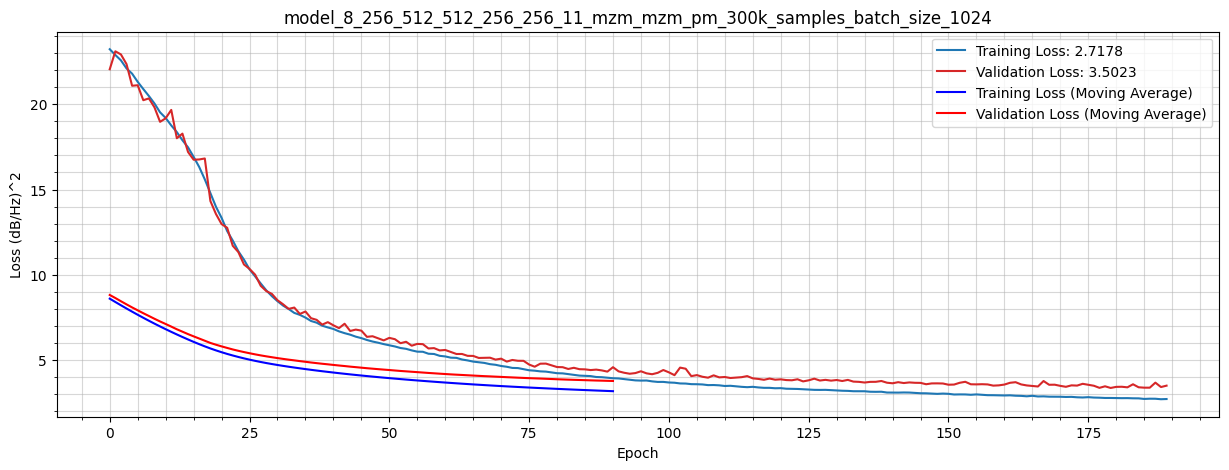

In [28]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name, ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

Normalized Loss: 0.000008
Denormalized Loss: 0.288602 (dB/Hz)^2


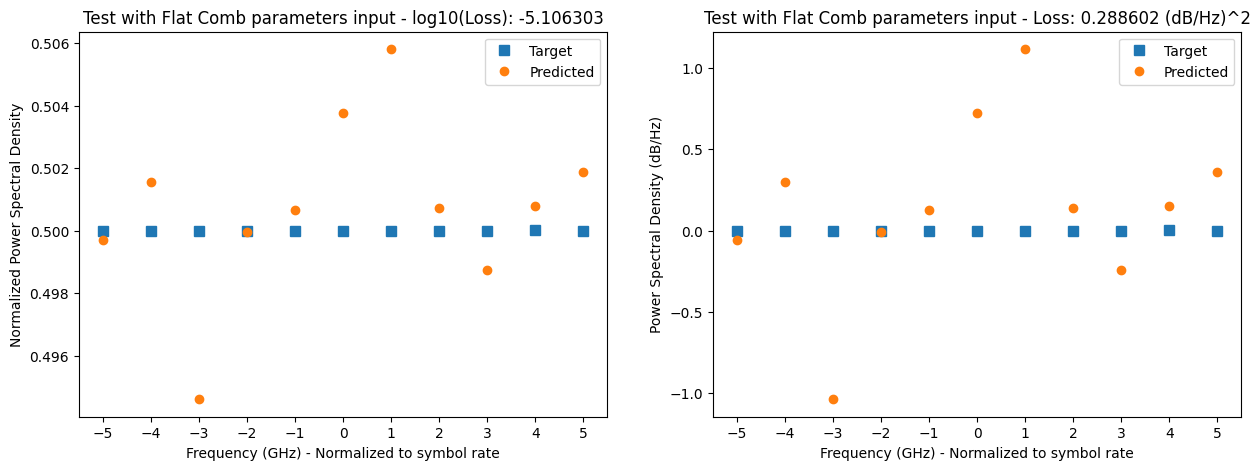

In [135]:
# Test with flat comb
model.eval() # Set model to evaluation mode
with torch.no_grad():
    params = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06] # flat comb parameters

    input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = torch.tensor(frequencyCombPeaks(params, ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = target_non_norm - torch.mean(target_non_norm)
    target = train_dataset.normalize(target_non_norm)
    output = model(input)
    
#plot using subplots, side by side
freqs_GHz = np.linspace(-(ofc_args.n_peaks//2),ofc_args.n_peaks//2,ofc_args.n_peaks) # Frequency range in GHz for n_peaks

fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(freqs_GHz,target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
ax[0].plot(freqs_GHz,output.squeeze().cpu().numpy(),"o", label='Predicted')
ax[0].set_xticks(freqs_GHz)
ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
ax[0].set_ylabel("Normalized Power Spectral Density")
ax[0].legend()
loss = criterion(output, target).item()
ax[0].set_title(f'Test with Flat Comb parameters input - log10(Loss): {np.log10(loss):.6f}')

print(f"Normalized Loss: {loss:.6f}")
print(f"Denormalized Loss: {convert_to_real_loss(loss, train_dataset.norm_scale):.6f} (dB/Hz)^2")

# Denormalize
output = train_dataset.denormalize(output)
target = train_dataset.denormalize(target)

ax[1].plot(freqs_GHz,target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
ax[1].plot(freqs_GHz,output.squeeze().cpu().numpy(),"o", label='Predicted')
ax[1].set_xticks(freqs_GHz)
ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
ax[1].legend()
#real_loss = convert_to_real_loss(loss, train_dataset.norm_scale)
real_loss = criterion(output, target).item()
ax[1].set_title(f'Test with Flat Comb parameters input - Loss: {real_loss:.6f} (dB/Hz)^2');

Test Loss: 5.959737 (dB/Hz)^2


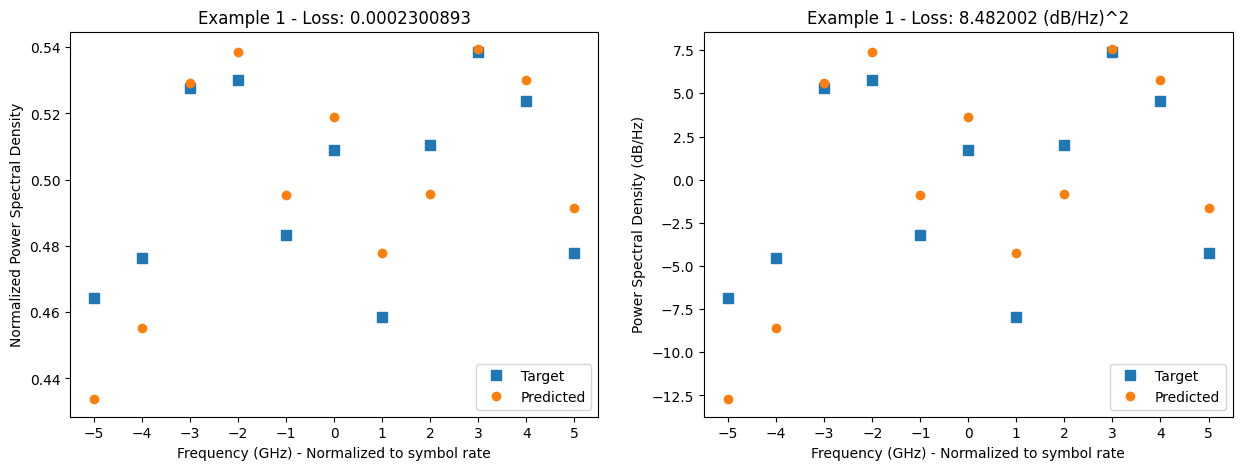

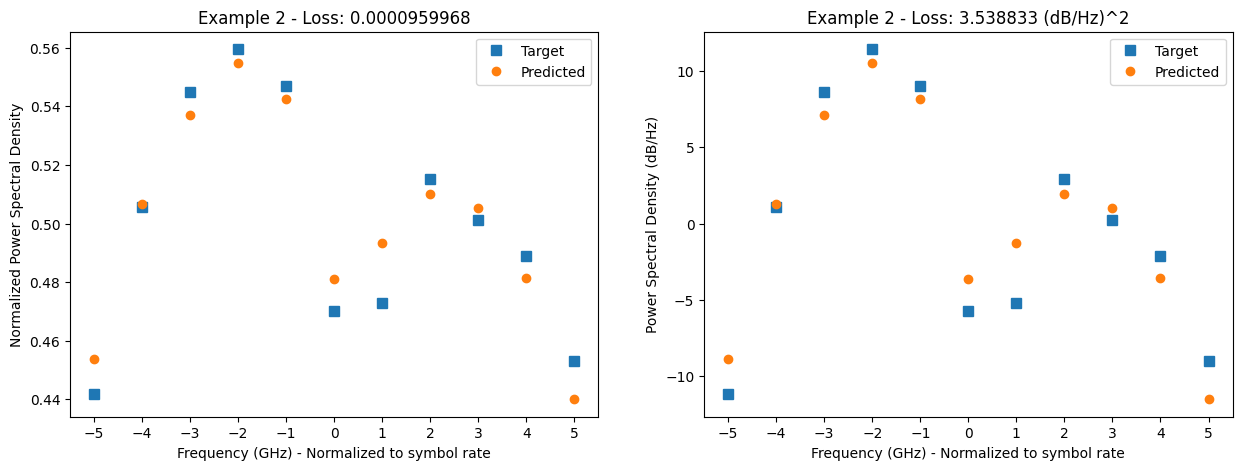

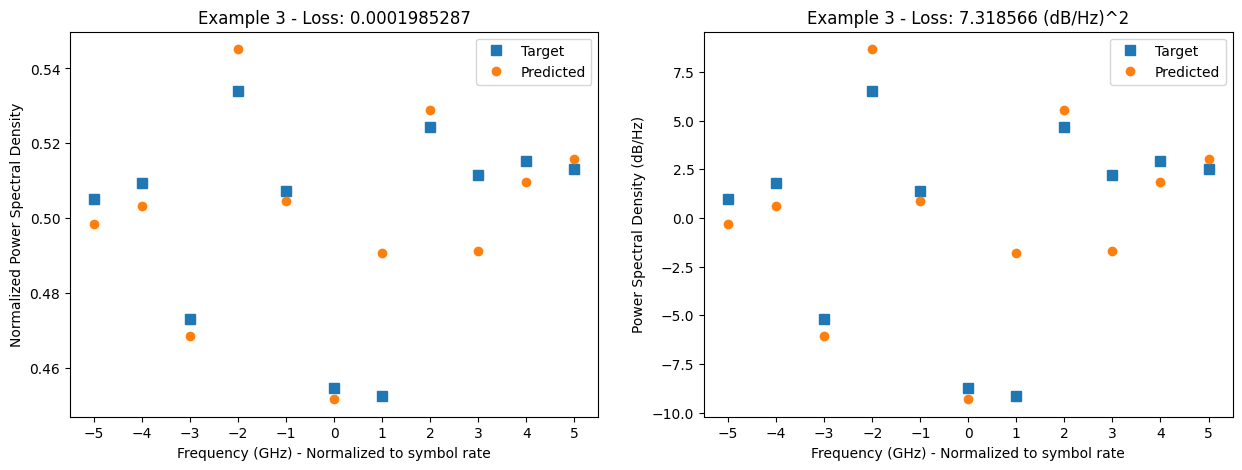

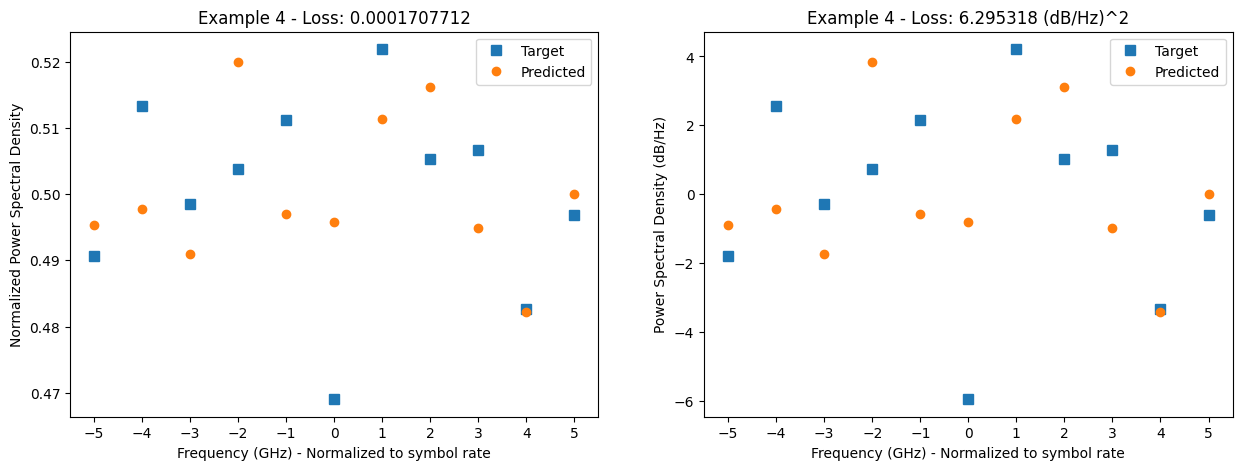

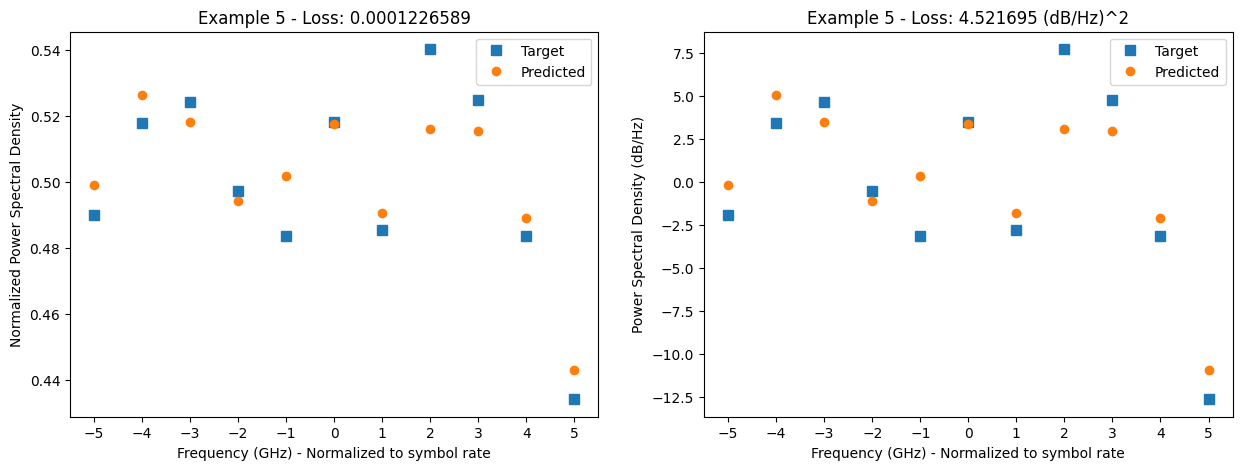

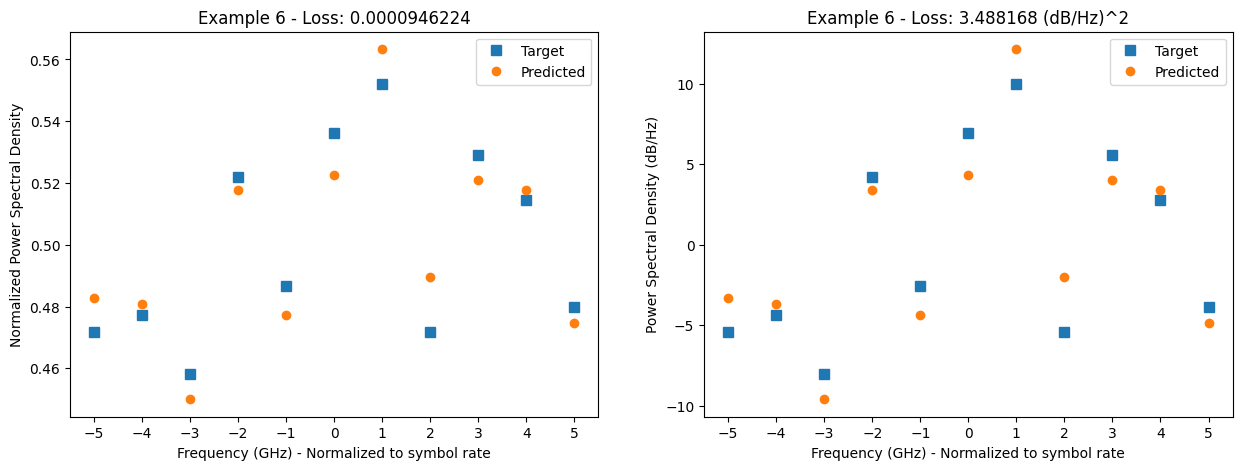

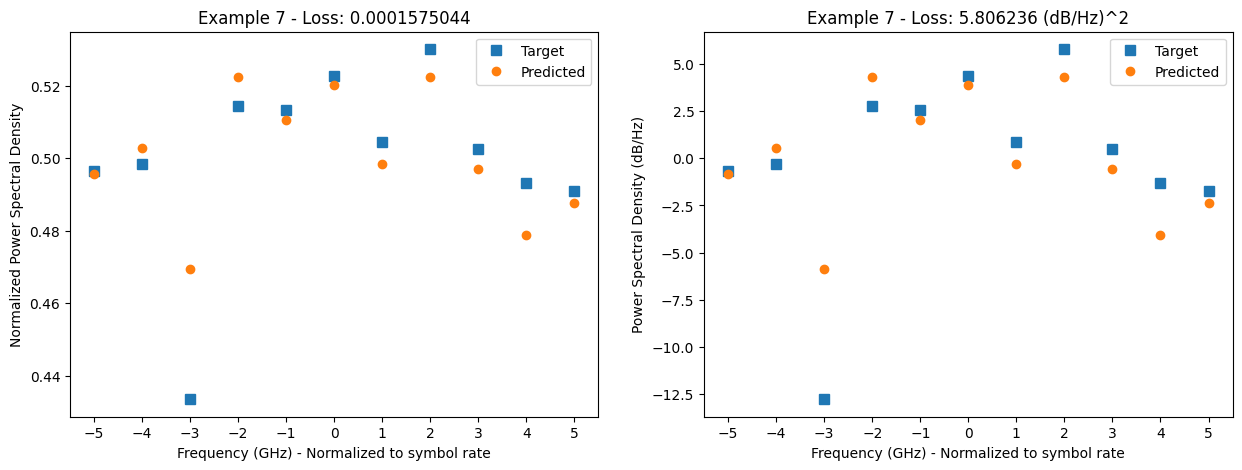

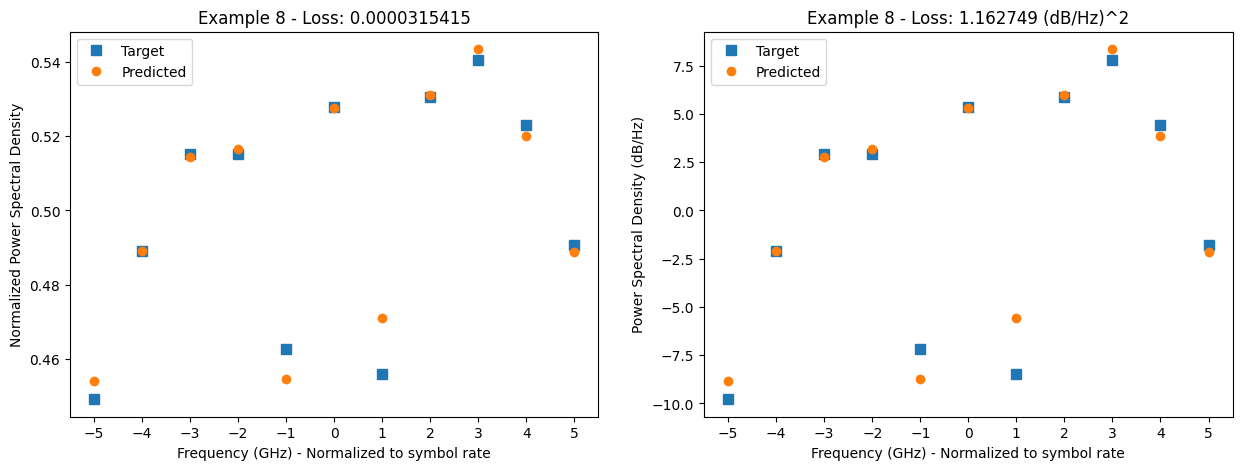

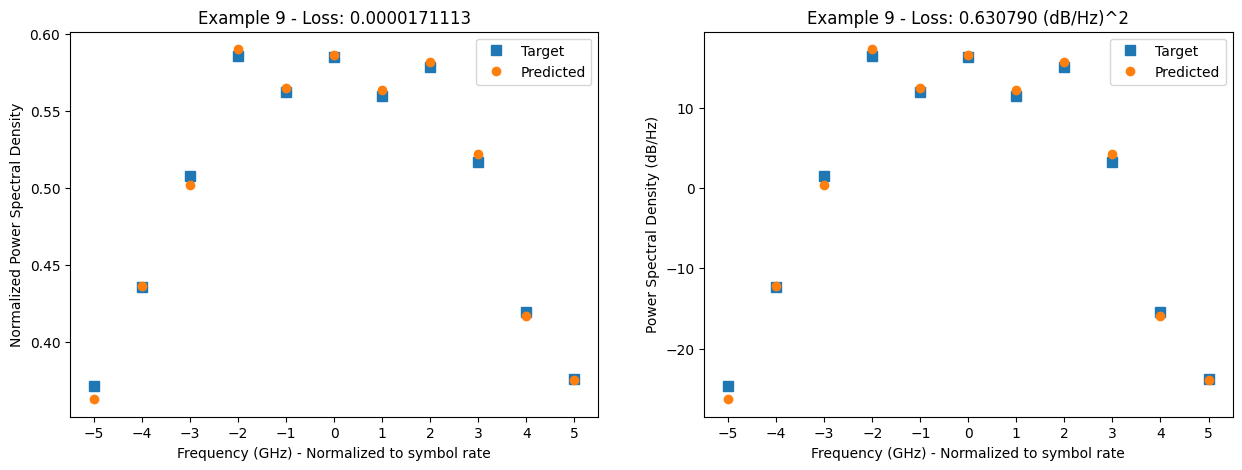

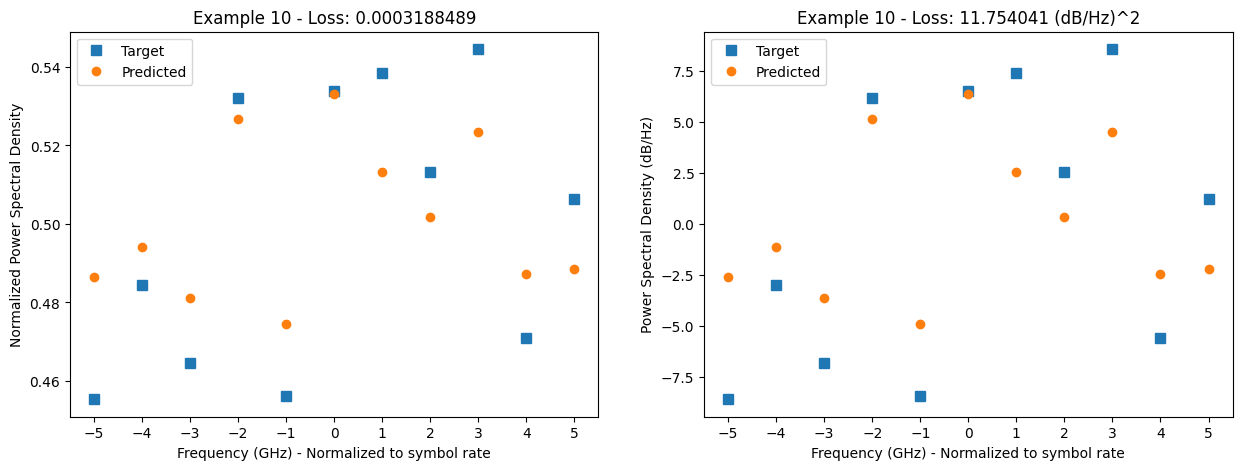

In [136]:
# Test phase
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    running_test_loss = 0.0
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        test_loss = criterion(outputs, targets)
        running_test_loss += test_loss.item() * inputs.size(0)
    avg_test_loss = running_test_loss / len(test_loader.dataset)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scale):.6f} (dB/Hz)^2")


for i in range(min(10, inputs.shape[0])):  # Loop over the first n examples

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(freqs_GHz,targets[i].cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(freqs_GHz,outputs[i].cpu().numpy(),"o", label='Predicted')
    ax[0].set_xticks(freqs_GHz)
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend()
    ax[0].set_title(f'Example {i+1} - Loss: {criterion(outputs[i], targets[i]).item():.10f}')

    # Denormalize
    outputs_denorm = train_dataset.denormalize(outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    ax[1].plot(freqs_GHz,targets_denorm.cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(freqs_GHz,outputs_denorm.cpu().numpy(),"o", label='Predicted')
    ax[1].set_xticks(freqs_GHz)
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
    ax[1].legend()
    ax[1].set_title(f'Example {i+1} - Loss: {criterion(outputs_denorm, targets_denorm).item():.6f} (dB/Hz)^2')

## <a id='toc3_2_'></a>[Inverse Network](#toc0_)

In [117]:
model_name

'model_8_256_256_256_256_11_mzm_mzm_pm_300k_samples_batch_size_1024'

In [118]:
# Load the pre-trained forward model
#model_name = "model_8_256_512_512_256_256_11_mzm_mzm_pm_300k_samples_batch_size_1024"
forward_model_name = "saved_data/models/" + model_name + ".pth"

model_dict_data = torch.load(forward_model_name)
forward_architecture = get_architecture(model_dict_data)
forward_net = FrequencyCombNet(forward_architecture).to(device)
forward_net.load_state_dict(model_dict_data)  # Load pre-trained weights
forward_net.eval()  # Set model to evaluation mode

for p in forward_net.parameters():
    p.requires_grad = False  # Freeze the weights and biases

# Create an inverse model with the same architecture but reversed
inverse_architecture = forward_architecture[::-1]
inverse_net = FrequencyCombNet(inverse_architecture).to(device)

# Loss Function
criterion = nn.MSELoss() # Mean Squared Error

# Optimizer
optimizer = torch.optim.Adam(inverse_net.parameters(), lr = 0.001) # lr - learning rate

train_losses = []
val_losses = []

### <a id='toc3_2_1_'></a>[Forward Network --> Inverse Network](#toc0_)

Epoch: 10/100.. Training loss: 2.713511 (dB/Hz)^2.. Validation Loss: 2.705692 (dB/Hz)^2


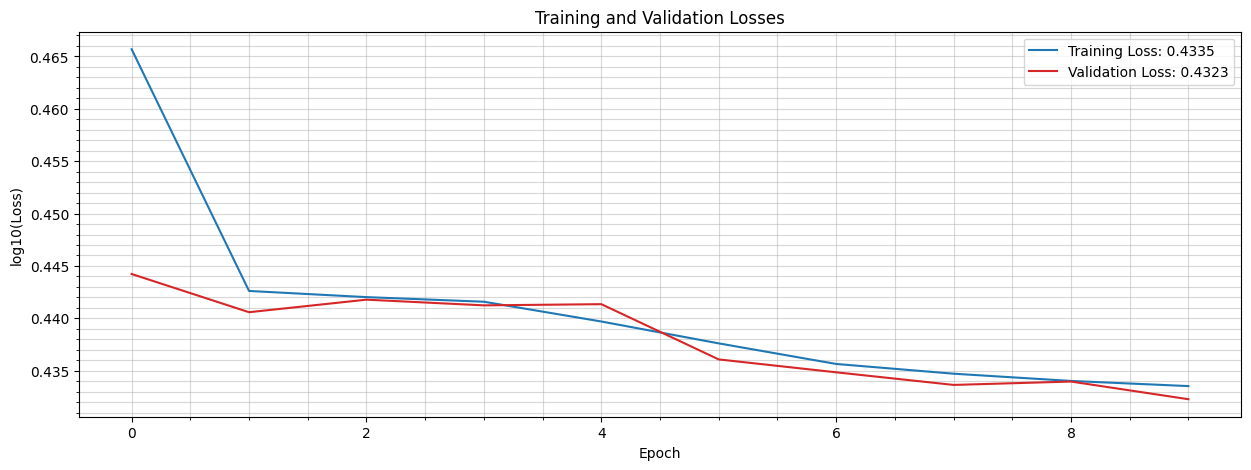

Epoch: 20/100.. Training loss: 2.700379 (dB/Hz)^2.. Validation Loss: 2.698658 (dB/Hz)^2


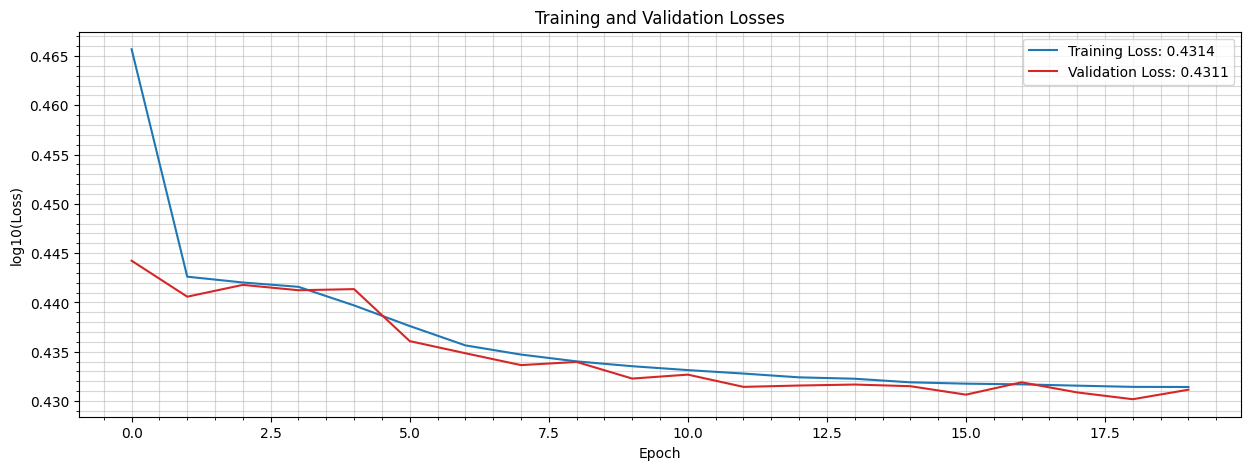

Epoch: 30/100.. Training loss: 2.694899 (dB/Hz)^2.. Validation Loss: 2.692784 (dB/Hz)^2


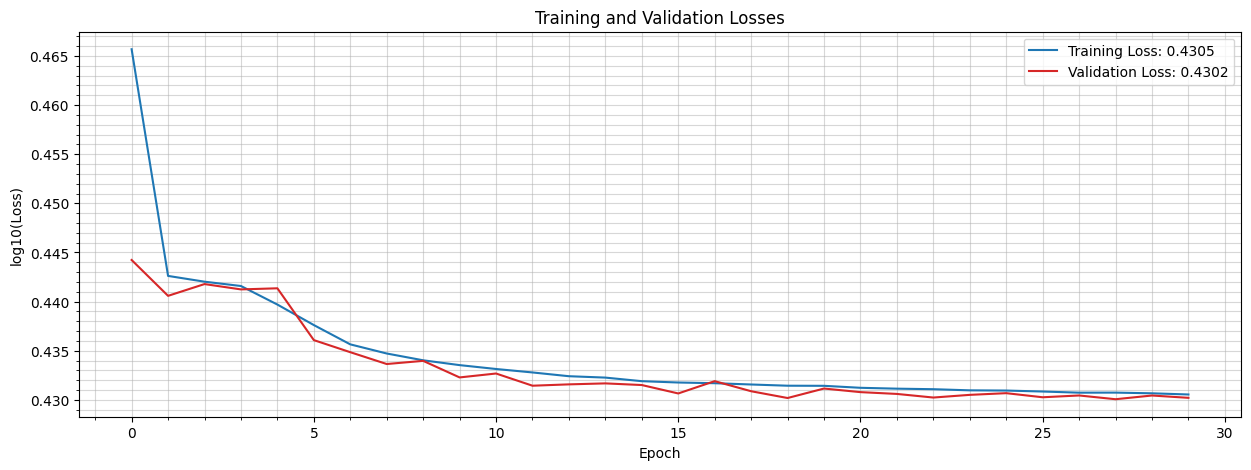

Epoch: 40/100.. Training loss: 2.691471 (dB/Hz)^2.. Validation Loss: 2.695551 (dB/Hz)^2


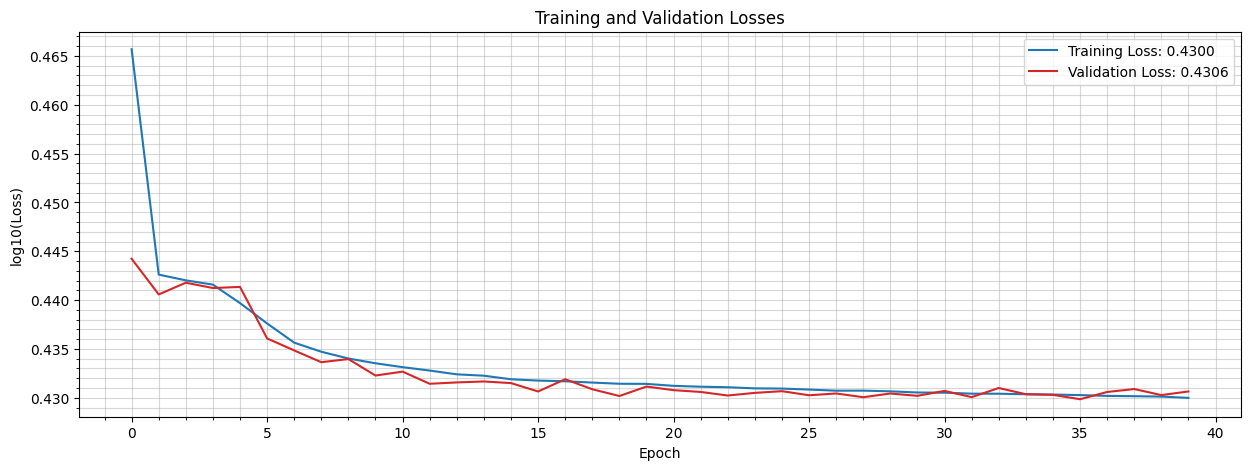

Epoch: 50/100.. Training loss: 2.687763 (dB/Hz)^2.. Validation Loss: 2.695087 (dB/Hz)^2


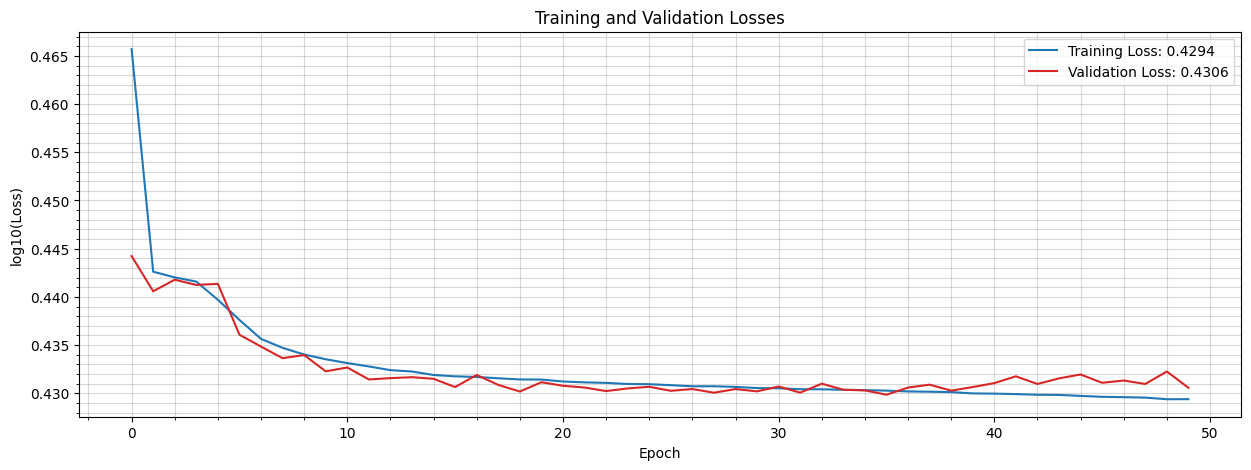

Epoch: 60/100.. Training loss: 2.682099 (dB/Hz)^2.. Validation Loss: 2.703360 (dB/Hz)^2


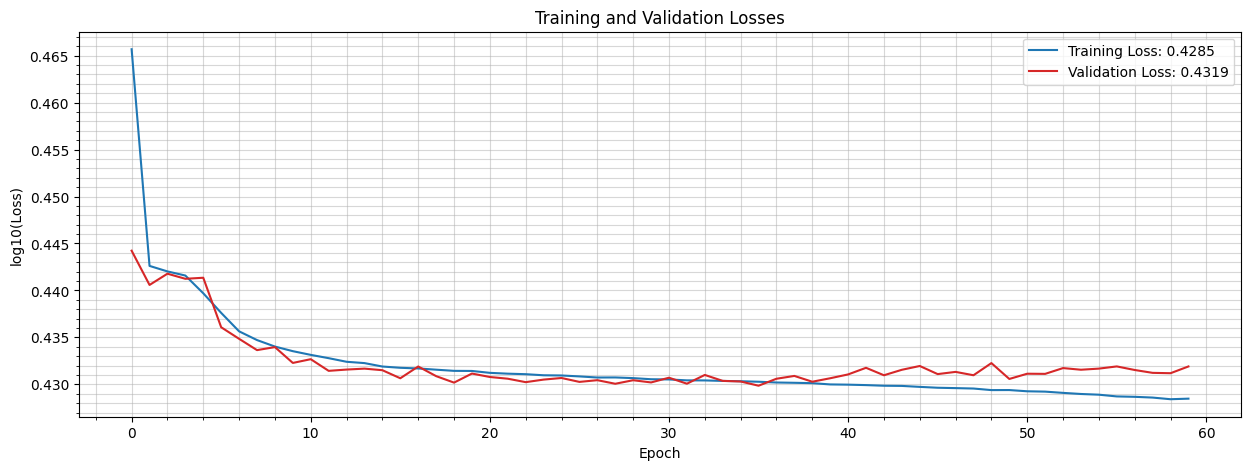

Epoch: 70/100.. Training loss: 2.674076 (dB/Hz)^2.. Validation Loss: 2.705535 (dB/Hz)^2


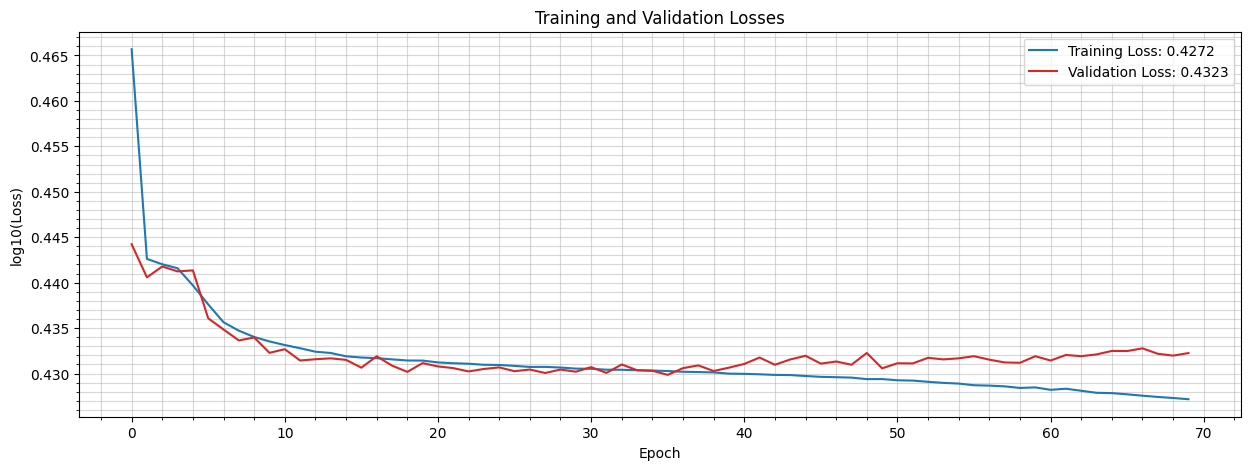

Epoch: 80/100.. Training loss: 2.666191 (dB/Hz)^2.. Validation Loss: 2.710946 (dB/Hz)^2


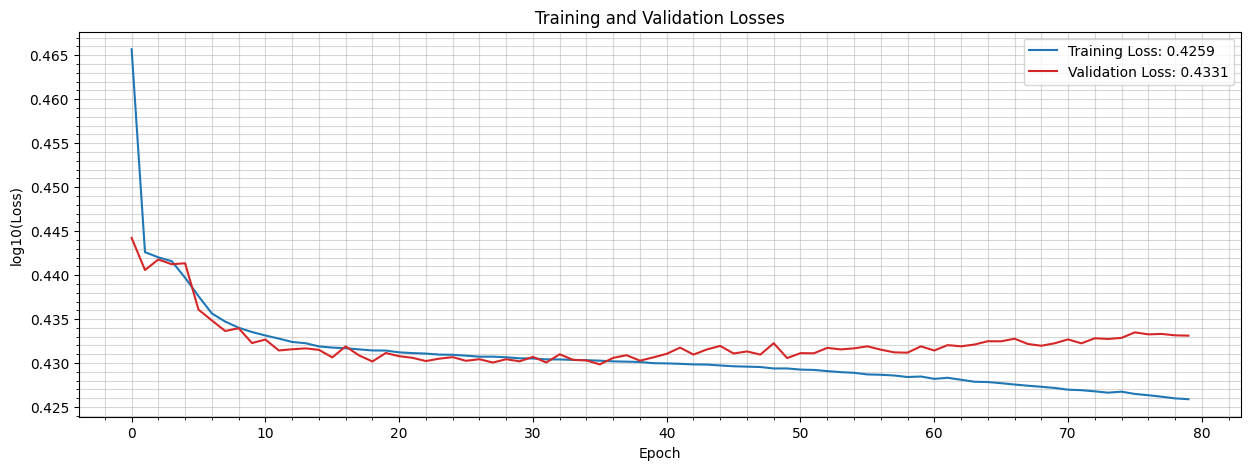

Epoch: 90/100.. Training loss: 2.658142 (dB/Hz)^2.. Validation Loss: 2.715918 (dB/Hz)^2


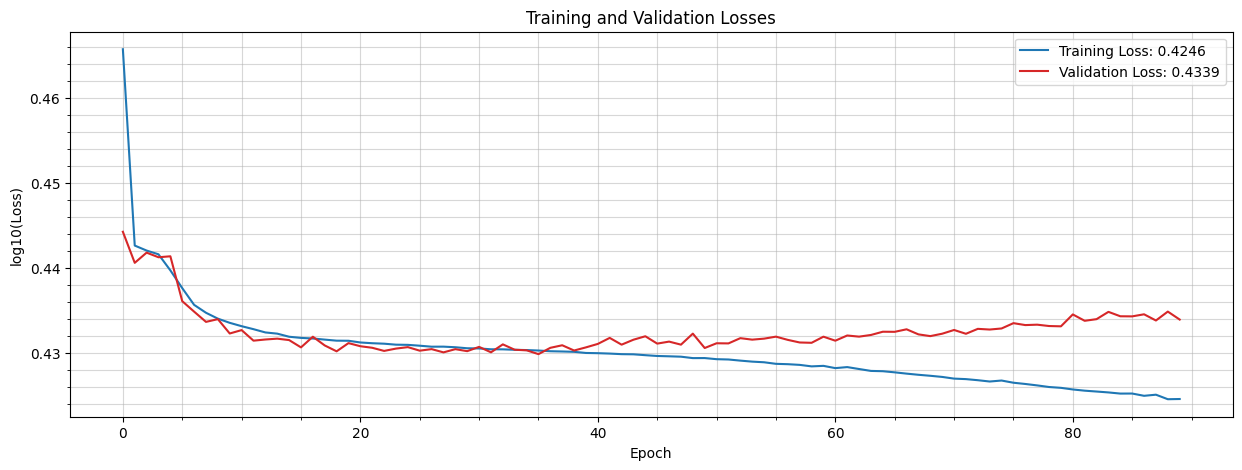

Epoch: 100/100.. Training loss: 2.648420 (dB/Hz)^2.. Validation Loss: 2.724369 (dB/Hz)^2


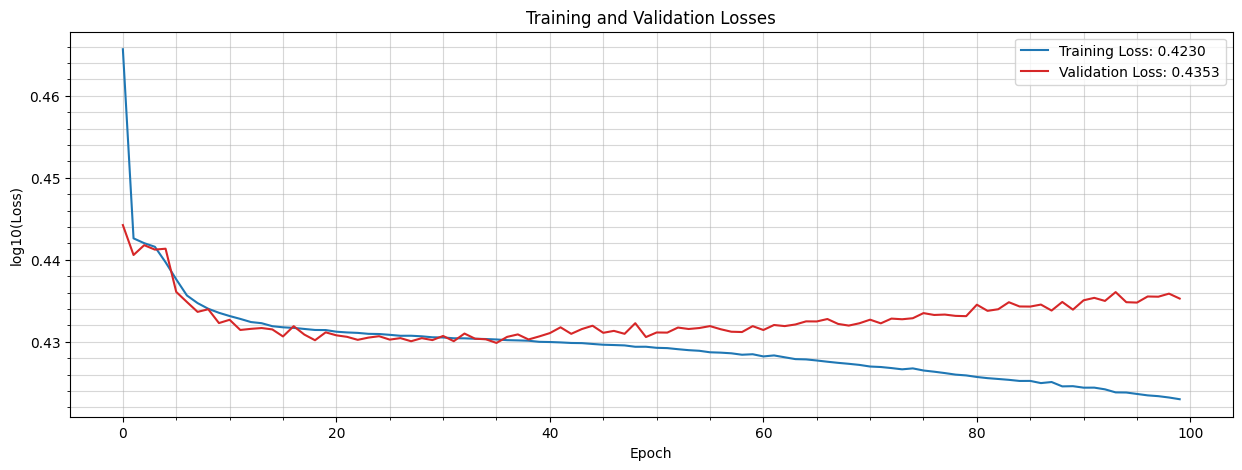

In [23]:
num_epochs = 100
val_loss_min = 1
for epoch in range(1, num_epochs + 1):

    # Training phase
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the forward model
        forward_outputs = forward_net(inputs)
        
        # Forward pass through the inverse model
        inverse_outputs = inverse_net(forward_outputs)

        # Calculate loss
        loss = criterion(inverse_outputs, inputs)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    #'''
    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, _ in val_loader:
            inputs = inputs.to(device)
            outputs = forward_net(inputs)
            inverse_outputs = inverse_net(outputs)
            val_loss = criterion(inverse_outputs, inputs)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch
    #'''

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}.. Training loss: {avg_train_loss:.6f}.. Validation Loss: {avg_val_loss:.6f}")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    '''
    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Saving model...')
        torch.save(inverse_net.state_dict(), model_name + "val_min_inverse_net_1.pth")
        val_loss_min = avg_val_loss
    '''


### <a id='toc3_2_2_'></a>[Inverse Network --> Forward Network](#toc0_)

Epoch: 500/5000... Training loss: 5.493391 (dB/Hz)^2 ... Validation Loss: 5.552716 (dB/Hz)^2


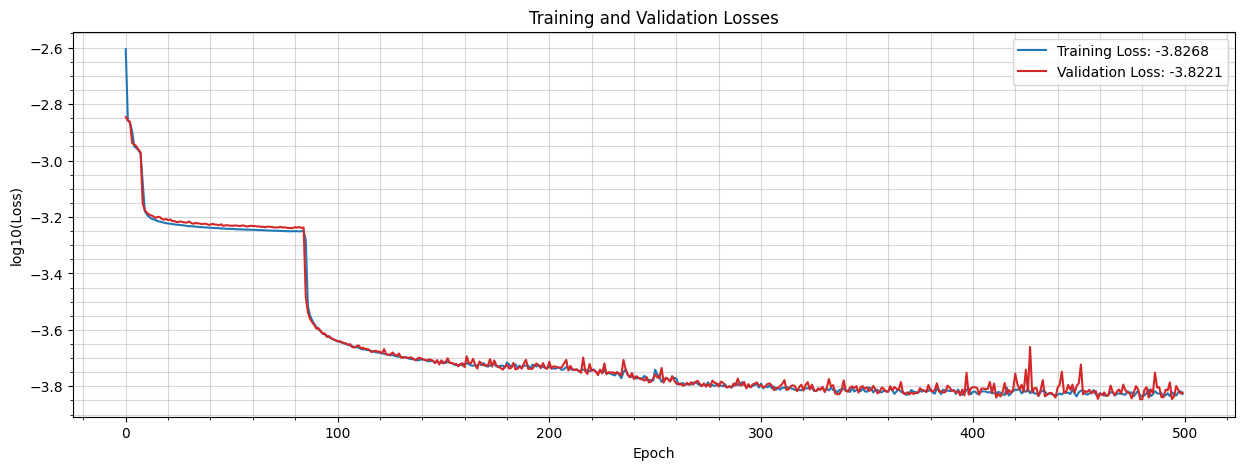

Validation loss decreased (0.000137 --> 0.000135). Epoch: 622. Saving model...
Validation loss decreased (0.000135 --> 0.000135). Epoch: 754. Saving model...
Validation loss decreased (0.000135 --> 0.000133). Epoch: 771. Saving model...
Epoch: 1000/5000... Training loss: 5.308067 (dB/Hz)^2 ... Validation Loss: 5.152327 (dB/Hz)^2


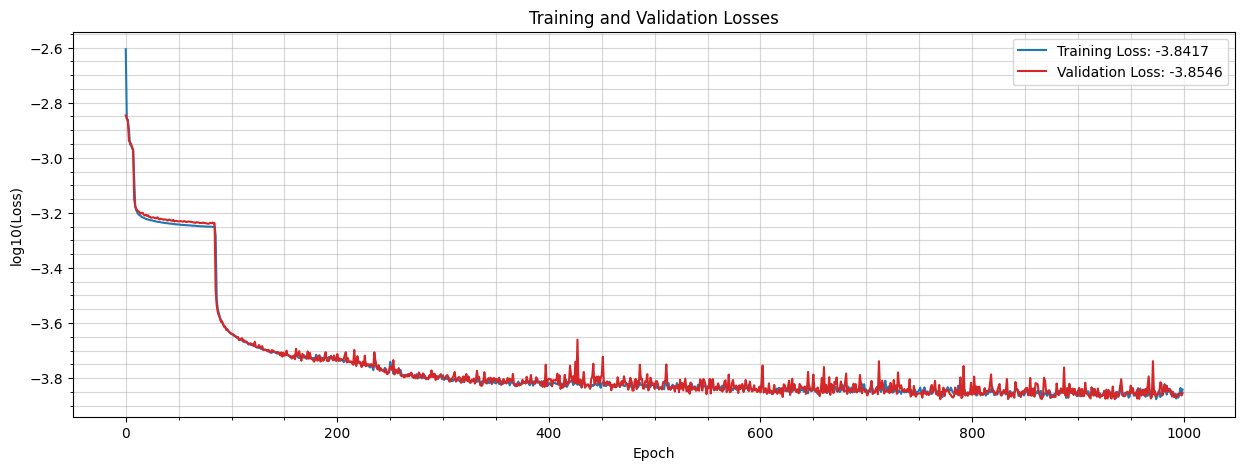

Validation loss decreased (0.000133 --> 0.000133). Epoch: 1048. Saving model...
Validation loss decreased (0.000133 --> 0.000132). Epoch: 1078. Saving model...
Validation loss decreased (0.000132 --> 0.000130). Epoch: 1091. Saving model...
Validation loss decreased (0.000130 --> 0.000130). Epoch: 1201. Saving model...
Validation loss decreased (0.000130 --> 0.000130). Epoch: 1305. Saving model...
Validation loss decreased (0.000130 --> 0.000129). Epoch: 1330. Saving model...
Validation loss decreased (0.000129 --> 0.000128). Epoch: 1418. Saving model...
Validation loss decreased (0.000128 --> 0.000127). Epoch: 1422. Saving model...
Epoch: 1500/5000... Training loss: 5.101070 (dB/Hz)^2 ... Validation Loss: 5.151678 (dB/Hz)^2


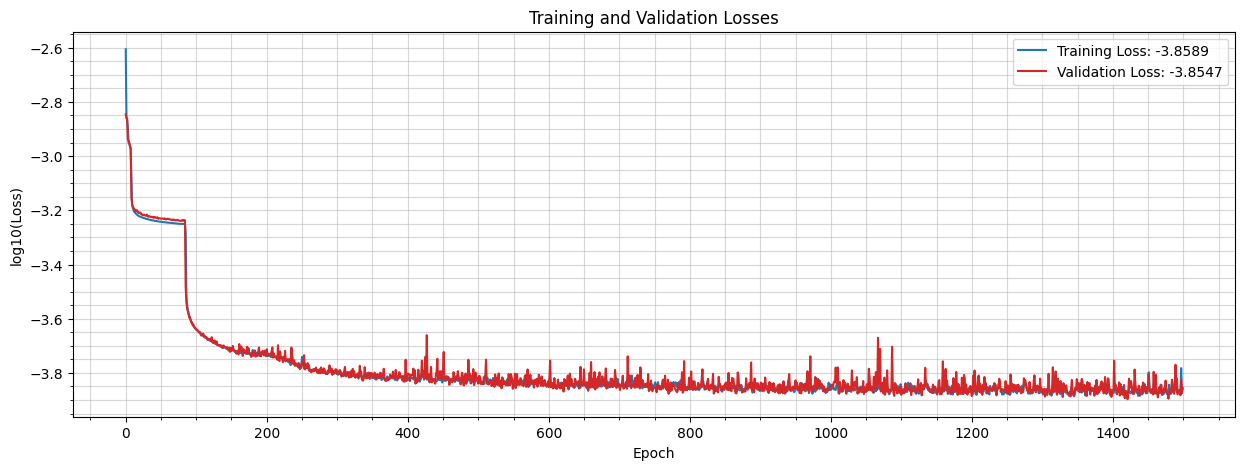

Validation loss decreased (0.000127 --> 0.000126). Epoch: 1684. Saving model...
Validation loss decreased (0.000126 --> 0.000126). Epoch: 1707. Saving model...
Validation loss decreased (0.000126 --> 0.000123). Epoch: 1914. Saving model...
Epoch: 2000/5000... Training loss: 4.812062 (dB/Hz)^2 ... Validation Loss: 4.814188 (dB/Hz)^2


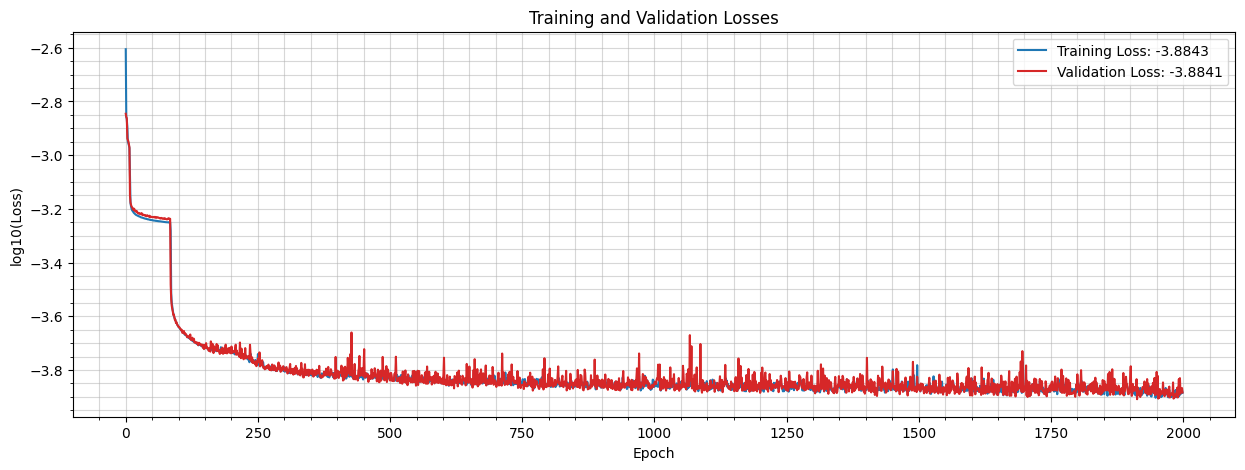

Validation loss decreased (0.000123 --> 0.000123). Epoch: 2358. Saving model...
Validation loss decreased (0.000123 --> 0.000123). Epoch: 2430. Saving model...
Validation loss decreased (0.000123 --> 0.000123). Epoch: 2437. Saving model...
Validation loss decreased (0.000123 --> 0.000122). Epoch: 2441. Saving model...
Epoch: 2500/5000... Training loss: 4.877016 (dB/Hz)^2 ... Validation Loss: 5.177565 (dB/Hz)^2


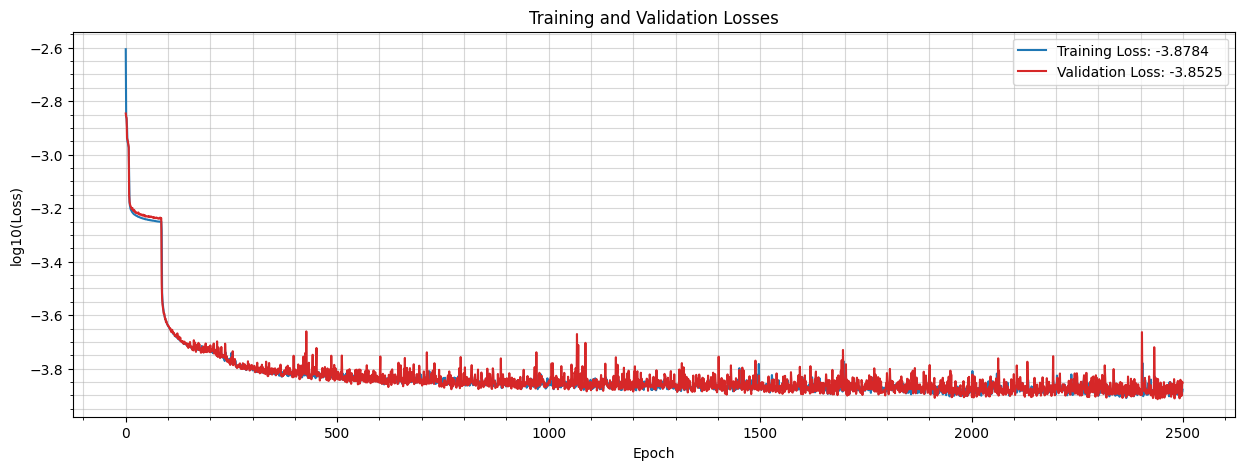

Validation loss decreased (0.000122 --> 0.000122). Epoch: 2507. Saving model...
Validation loss decreased (0.000122 --> 0.000122). Epoch: 2553. Saving model...
Validation loss decreased (0.000122 --> 0.000121). Epoch: 2579. Saving model...
Validation loss decreased (0.000121 --> 0.000121). Epoch: 2869. Saving model...
Epoch: 3000/5000... Training loss: 4.732457 (dB/Hz)^2 ... Validation Loss: 4.707543 (dB/Hz)^2


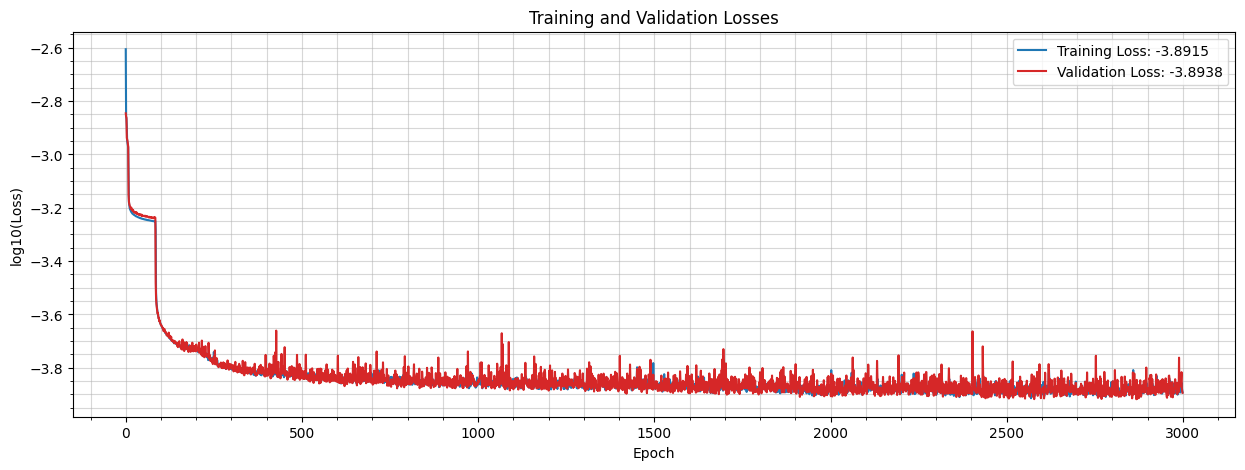

Validation loss decreased (0.000121 --> 0.000121). Epoch: 3221. Saving model...
Validation loss decreased (0.000121 --> 0.000120). Epoch: 3230. Saving model...
Validation loss decreased (0.000120 --> 0.000119). Epoch: 3414. Saving model...
Validation loss decreased (0.000119 --> 0.000118). Epoch: 3417. Saving model...
Epoch: 3500/5000... Training loss: 4.756806 (dB/Hz)^2 ... Validation Loss: 4.709801 (dB/Hz)^2


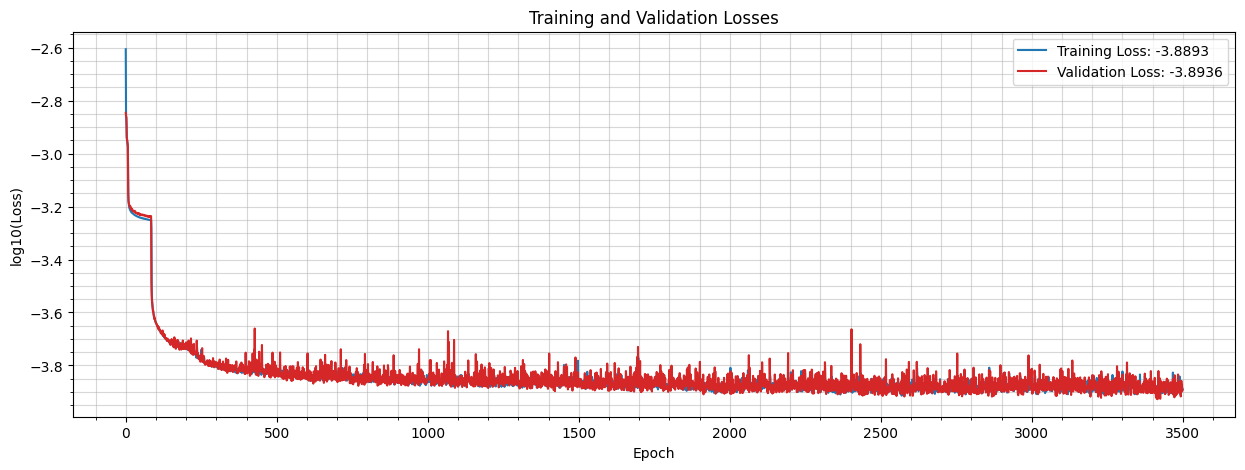

Validation loss decreased (0.000118 --> 0.000118). Epoch: 3700. Saving model...
Epoch: 4000/5000... Training loss: 4.775731 (dB/Hz)^2 ... Validation Loss: 4.810502 (dB/Hz)^2


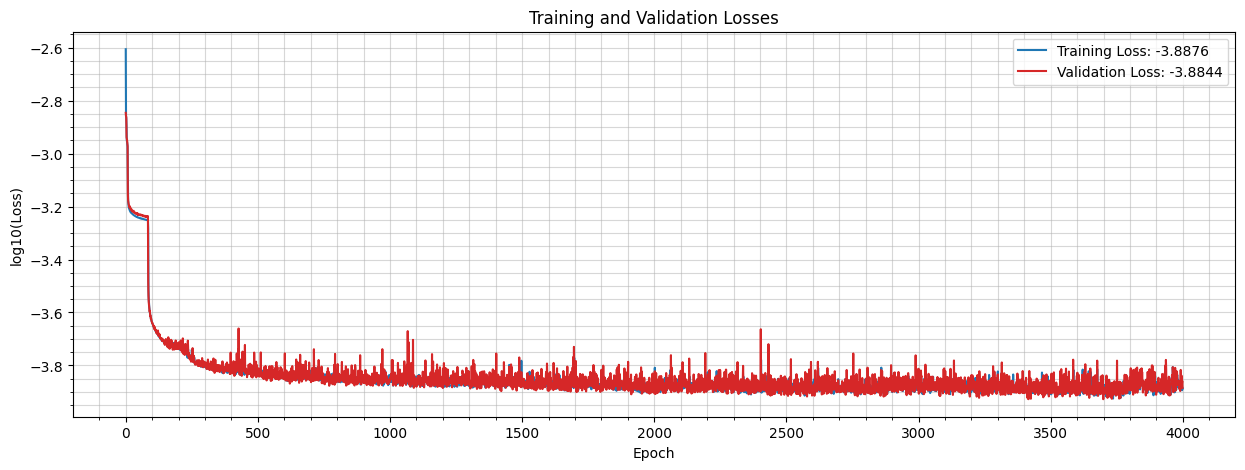

Validation loss decreased (0.000118 --> 0.000117). Epoch: 4222. Saving model...
Epoch: 4500/5000... Training loss: 4.451606 (dB/Hz)^2 ... Validation Loss: 4.719012 (dB/Hz)^2


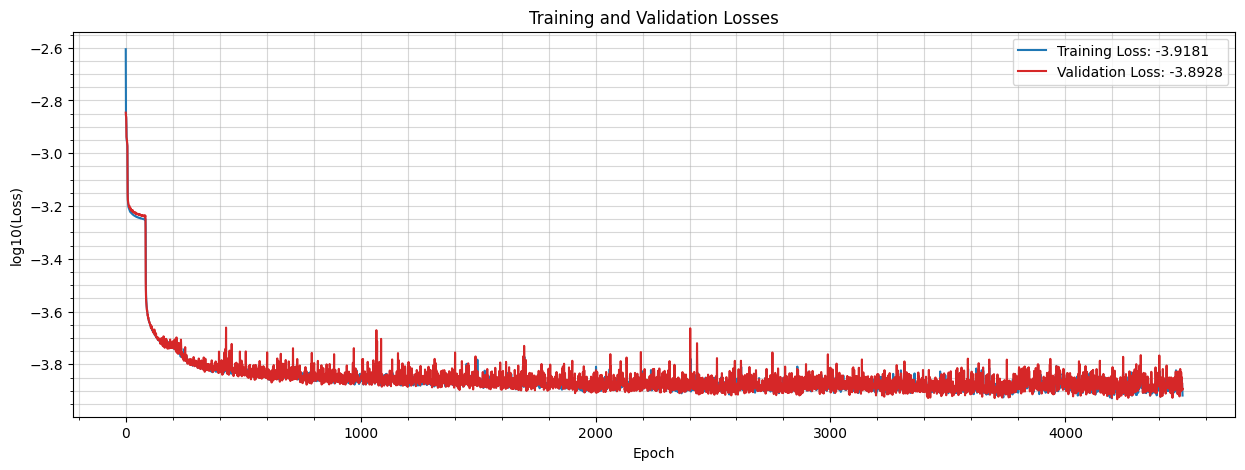

Epoch: 5000/5000... Training loss: 4.844622 (dB/Hz)^2 ... Validation Loss: 5.060922 (dB/Hz)^2


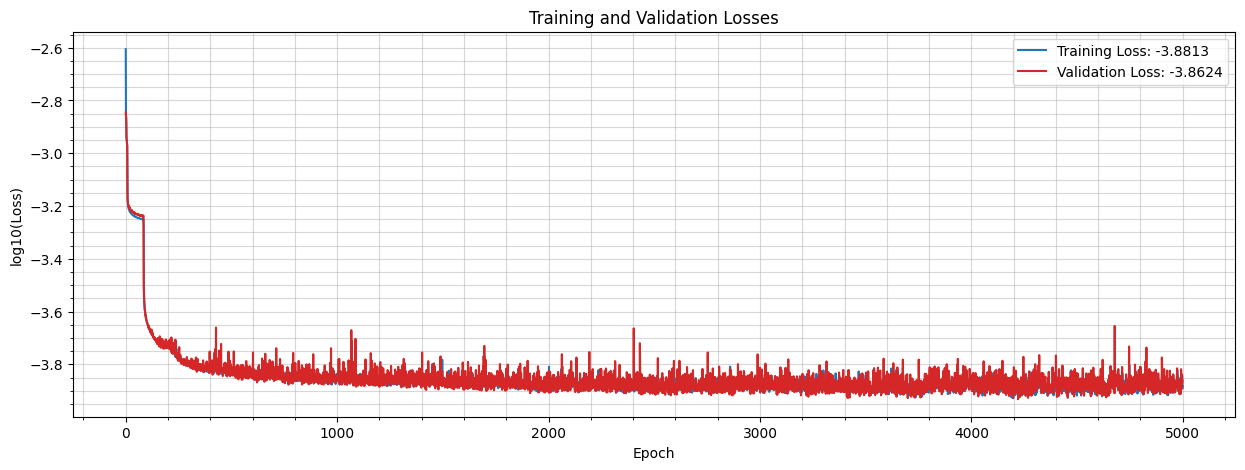

In [119]:
num_epochs = 5000
val_loss_min = 1
for epoch in range(1, num_epochs + 1):

    # Training phase
    forward_net.eval()  # Set model to evaluation mode
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for _, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        targets = targets.to(device)

        # Forward pass through the inverse model
        inverse_outputs = inverse_net(targets)

        # Forward pass through the forward model
        forward_outputs = forward_net(inverse_outputs)

        # Calculate loss
        loss = criterion(forward_outputs, targets)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * targets.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for _, targets in val_loader:
            targets = targets.to(device)
            inverse_outputs = inverse_net(targets)
            forward_outputs = forward_net(inverse_outputs)
            val_loss = criterion(forward_outputs, targets)
            running_val_loss += val_loss.item() * targets.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {convert_to_real_loss(avg_train_loss, train_dataset.norm_scale):.6f} (dB/Hz)^2 ... Validation Loss: {convert_to_real_loss(avg_val_loss, train_dataset.norm_scale):.6f} (dB/Hz)^2")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")

    #'''
    # Save model if validation loss has decreased
    if avg_val_loss <= val_loss_min:
        print(f'Validation loss decreased ({val_loss_min:.6f} --> {avg_val_loss:.6f}). Epoch: {epoch}. Saving model...')
        torch.save(inverse_net.state_dict(), model_name + "val_min_inverse_net.pth")
        val_loss_min = avg_val_loss
    #'''

In [120]:
# Save the inverse model
torch.save(inverse_net.state_dict(), model_name + "inverse_net.pth")

#save training and validation losses for the inverse model
inverse_train_losses_path = "saved_data/losses/" + model_name + '_inverse_train_losses.npy'
inverse_val_losses_path = "saved_data/losses/" + model_name + '_inverse_val_losses.npy'
np.save(inverse_train_losses_path, np.array(train_losses))
np.save(inverse_val_losses_path, np.array(val_losses))

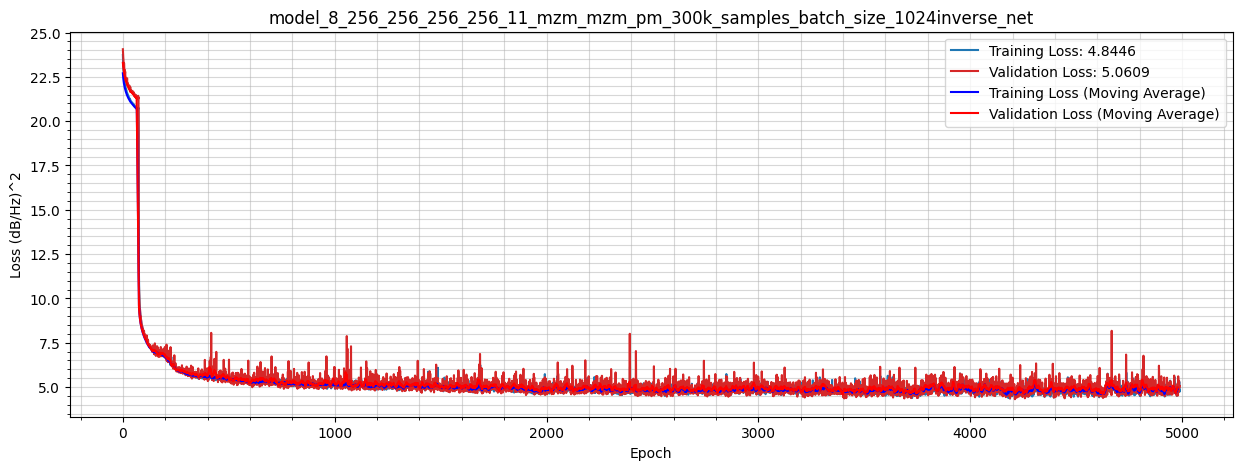

In [121]:
plot_training_progress(convert_to_real_loss(train_losses, train_dataset.norm_scale)[10:], convert_to_real_loss(val_losses, train_dataset.norm_scale)[10:], title = model_name  + "inverse_net", ylabel = "Loss (dB/Hz)^2",  average_curves = True, M = 10)

Normalized Loss: 0.000076
Denormalized Loss: 2.809357 (dB/Hz)^2


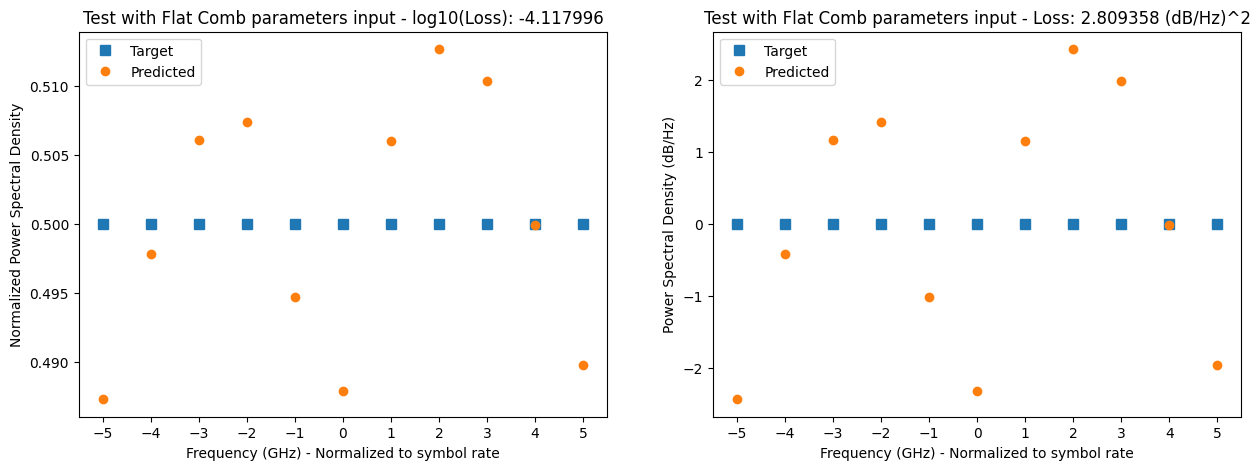

In [124]:
# Test with flat comb
inverse_net.eval() # Set inverse_net to evaluation mode
with torch.no_grad():
    params = [2.7442043, 1.9302677, 2.4303038, 1.2577362, 0.7501987, 0.8391744, 2.0000486, 2.0055982e-06] # flat comb parameters

    input = torch.tensor(params, dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = torch.tensor(frequencyCombPeaks(params, ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
    target_non_norm = target_non_norm - torch.mean(target_non_norm)
    target = train_dataset.normalize(target_non_norm)
    
    inverse_output = inverse_net(target)
    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_output.cpu().numpy()[0], ofc_args), dtype=torch.float32).unsqueeze(0).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

#plot using subplots, side by side
fig, ax = plt.subplots(1,2,figsize = (15,5))
ax[0].plot(freqs_GHz,target.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
ax[0].plot(freqs_GHz,inverse_peaks.squeeze().cpu().numpy(),"o", label='Predicted')
ax[0].set_xticks(freqs_GHz)
ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
ax[0].set_ylabel("Normalized Power Spectral Density")
ax[0].legend()
loss = criterion(inverse_peaks, target).item()
ax[0].set_title(f'Test with Flat Comb parameters input - log10(Loss): {np.log10(loss):.6f}')

print(f"Normalized Loss: {loss:.6f}")
print(f"Denormalized Loss: {convert_to_real_loss(loss, train_dataset.norm_scale):.6f} (dB/Hz)^2")

# Denormalize
inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)
target_denorm = train_dataset.denormalize(target)

ax[1].plot(freqs_GHz,target_denorm.squeeze().cpu().numpy(),"s", label='Target',markersize=7)
ax[1].plot(freqs_GHz,inverse_peaks_denorm.squeeze().cpu().numpy(),"o", label='Predicted')
ax[1].set_xticks(freqs_GHz)
ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
ax[1].set_ylabel("Power Spectral Density (dB/Hz)")
ax[1].legend()
#real_loss = convert_to_real_loss(loss)
real_loss = criterion(inverse_peaks_denorm, target_denorm).item()
ax[1].set_title(f'Test with Flat Comb parameters input - Loss: {real_loss:.6f} (dB/Hz)^2'); 

Test Loss: 5.116039 (dB/Hz)^2


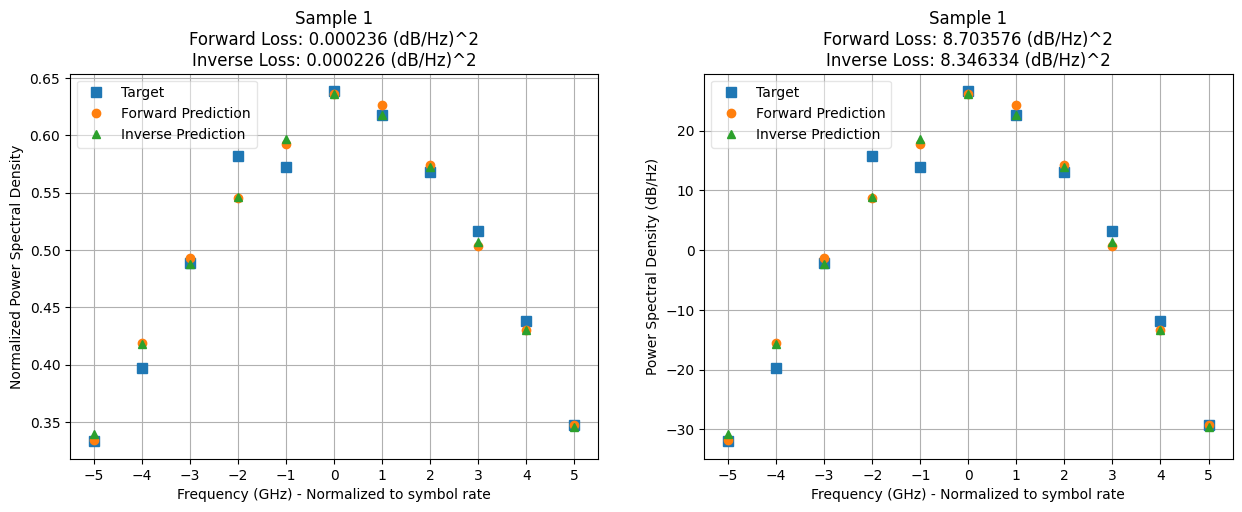

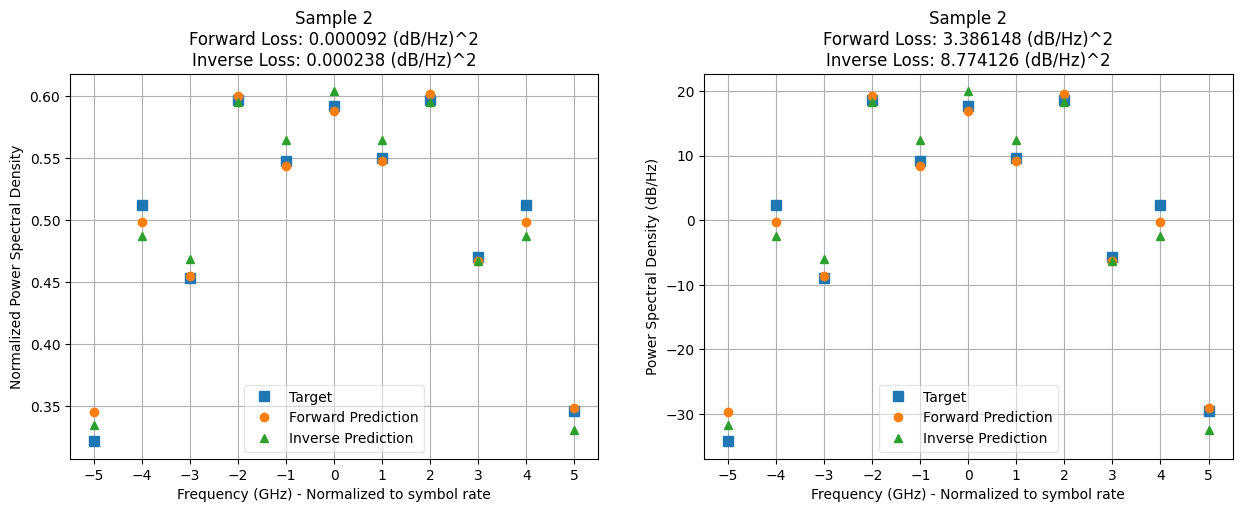

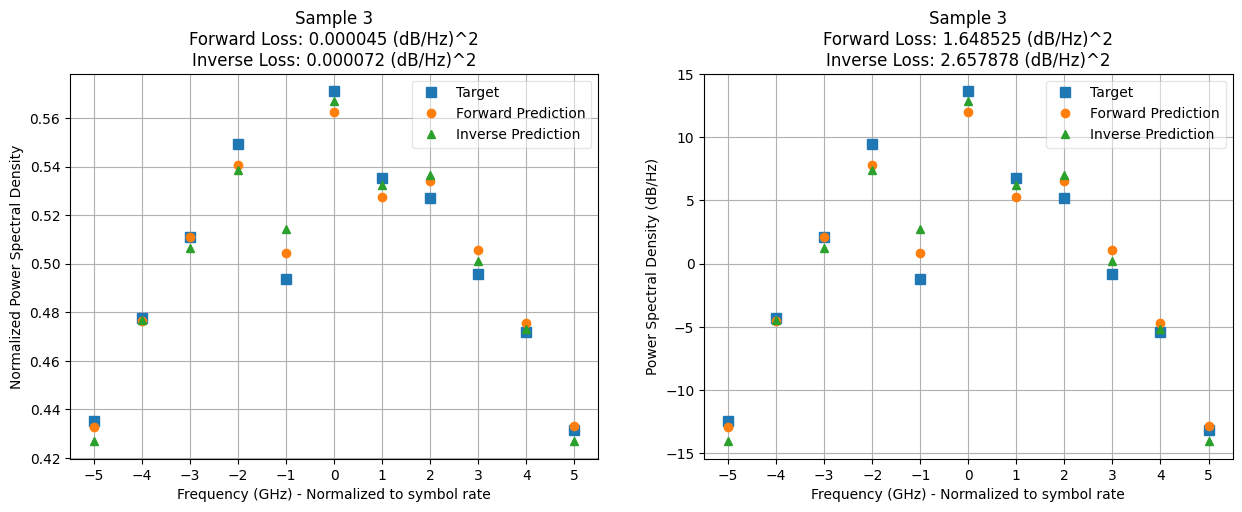

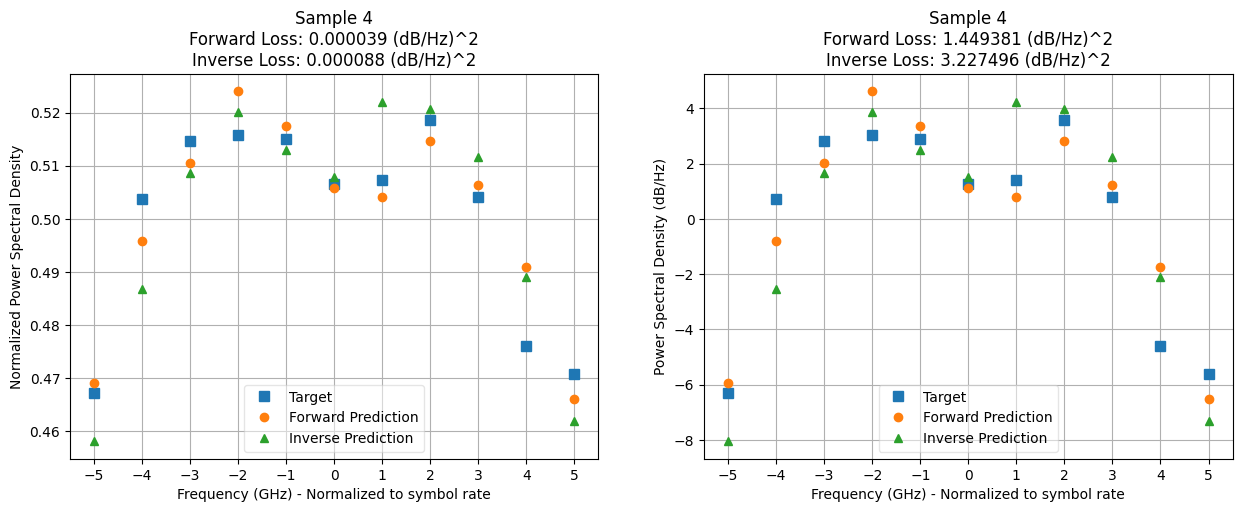

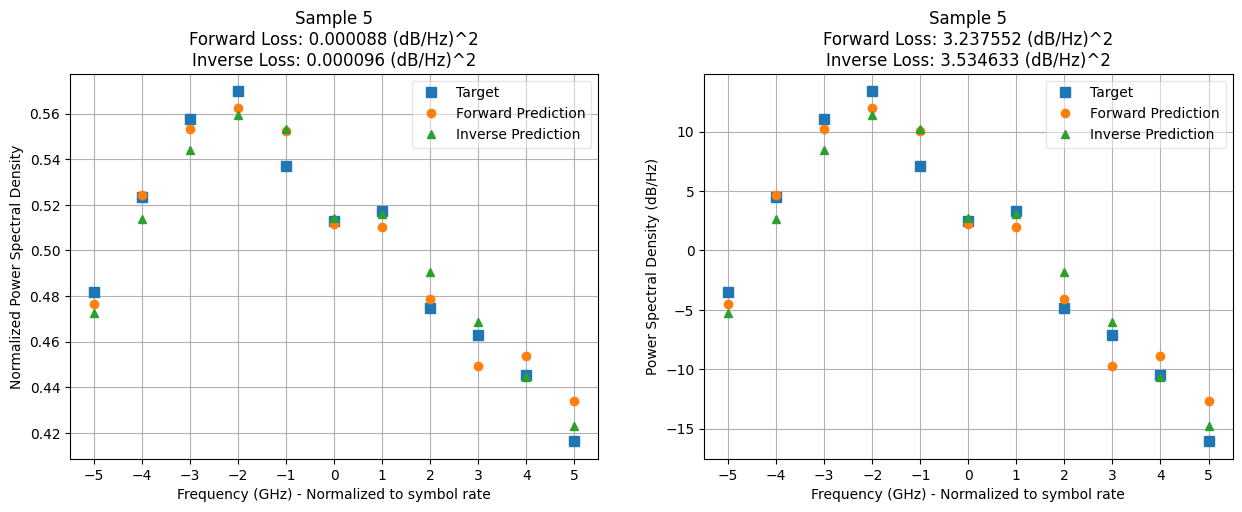

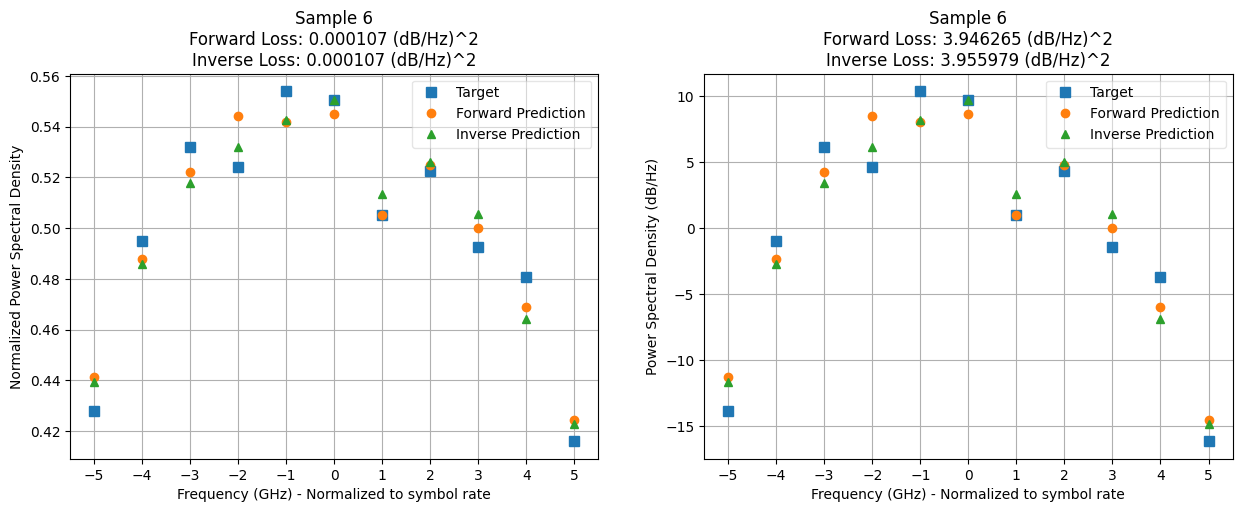

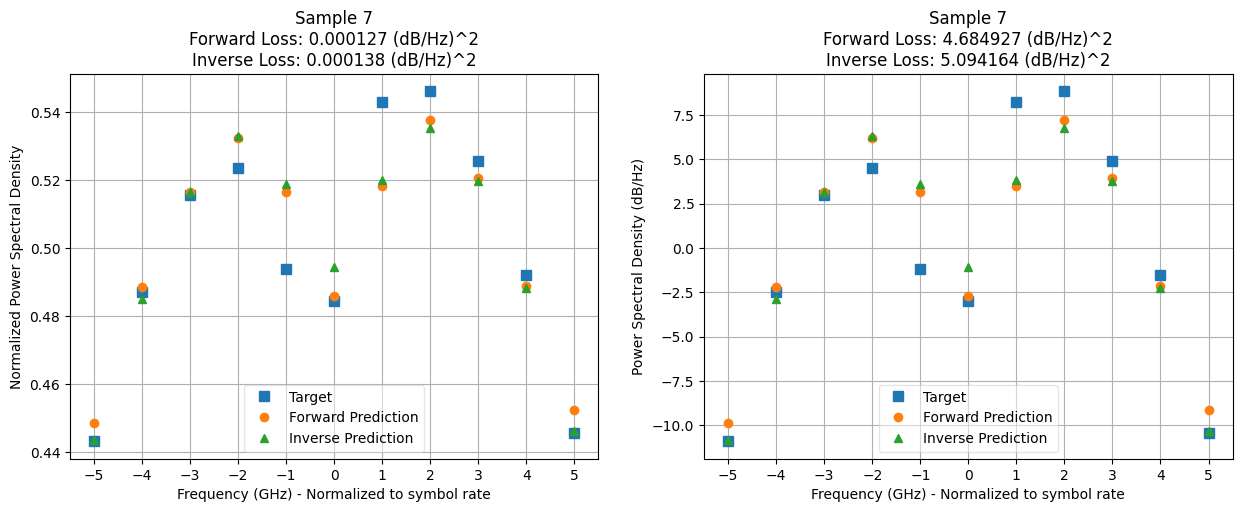

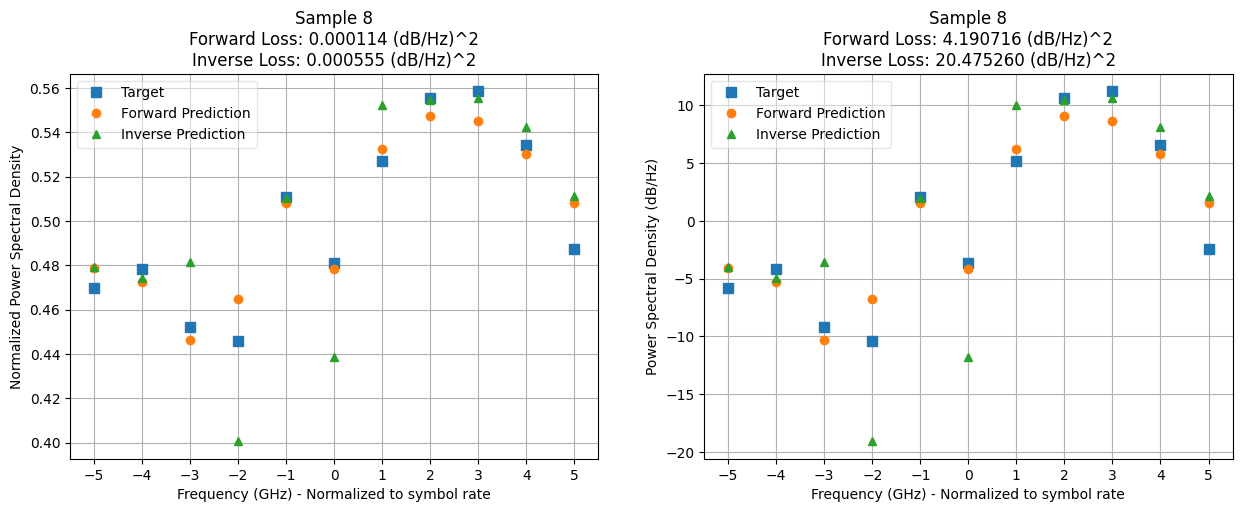

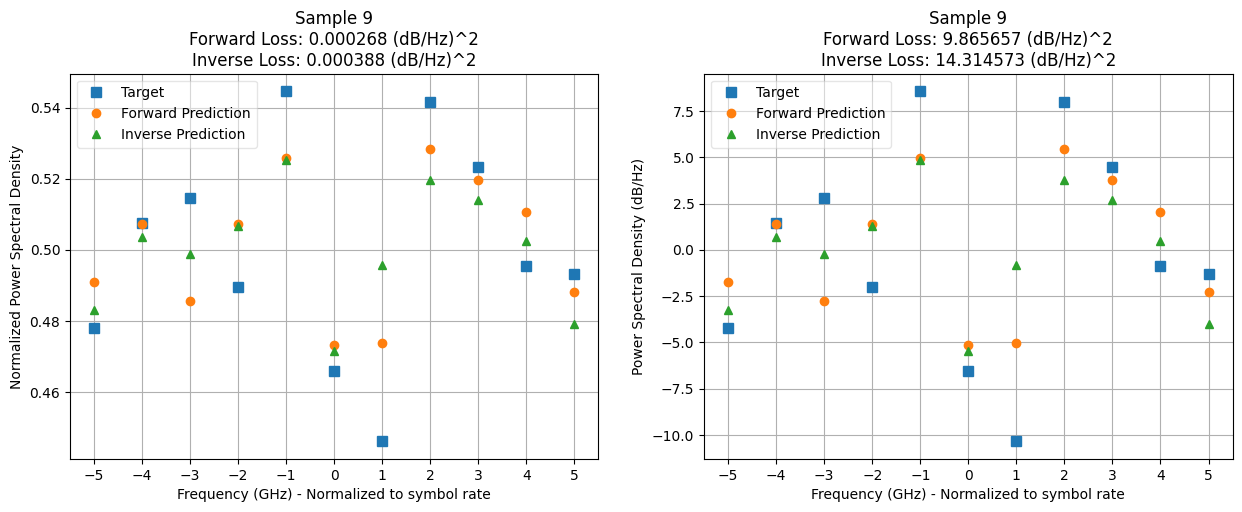

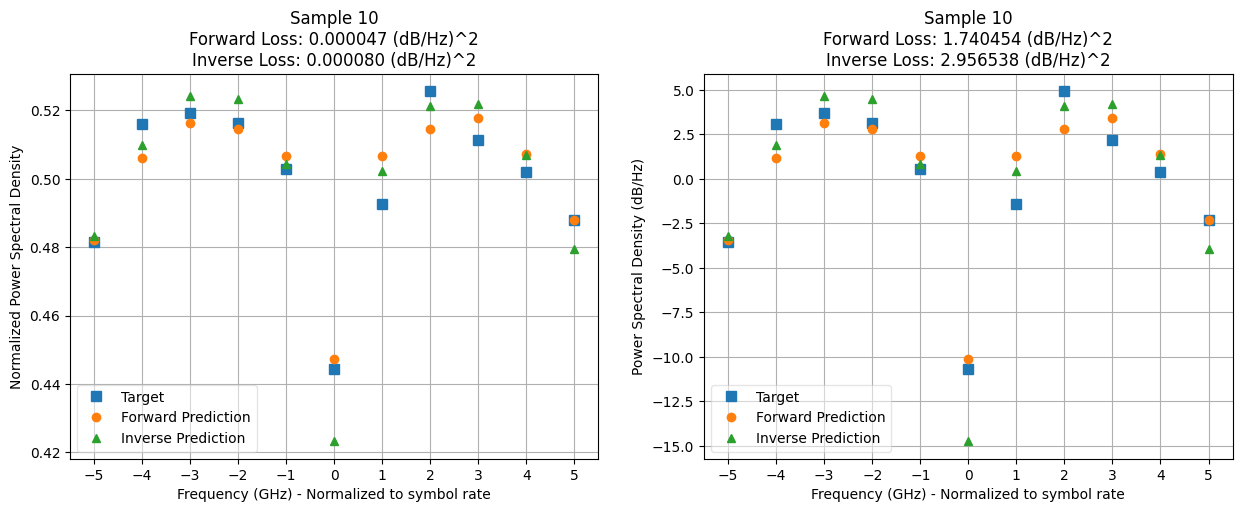

In [125]:
# Test phase
inverse_net.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    running_test_loss = 0.0
    for _, targets in test_loader:
        targets = targets.to(device)
        inverse_outputs = inverse_net(targets)
        forward_outputs = forward_net(inverse_outputs)
        test_loss = criterion(forward_outputs, targets)
        running_test_loss += test_loss.item() * targets.size(0)
    avg_test_loss = running_test_loss / len(test_loader.dataset)
print(f"Test Loss: {convert_to_real_loss(avg_test_loss, train_dataset.norm_scale):.6f} (dB/Hz)^2")

# Loop over the first n examples
for i in range(min(10, targets.shape[0])):

    inverse_peaks = torch.tensor(frequencyCombPeaks(inverse_outputs[i].cpu().numpy(), ofc_args), dtype=torch.float32).to(device)
    inverse_peaks = inverse_peaks - torch.mean(inverse_peaks)
    inverse_peaks = train_dataset.normalize(inverse_peaks)

    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    forward_loss = criterion(forward_outputs[i], targets[i]).item()
    inverse_loss = criterion(inverse_peaks, targets[i]).item()
    ax[0].plot(freqs_GHz,targets[i].cpu().numpy(),"s", label='Target',markersize=7)
    ax[0].plot(freqs_GHz,forward_outputs[i].cpu().numpy(),"o", label=f'Forward Prediction')
    ax[0].plot(freqs_GHz,inverse_peaks.cpu().numpy().squeeze(),"^", label=f'Inverse Prediction')
    ax[0].set_xticks(freqs_GHz)
    ax[0].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[0].set_ylabel("Normalized Power Spectral Density")
    ax[0].legend(framealpha=0.5)
    ax[0].set_title(f'Sample {i+1}\nForward Loss: {forward_loss:.6f} (dB/Hz)^2\nInverse Loss: {inverse_loss:.6f} (dB/Hz)^2')

    # Denormalize
    forward_outputs_denorm = train_dataset.denormalize(forward_outputs[i])
    targets_denorm = train_dataset.denormalize(targets[i])
    inverse_peaks_denorm = train_dataset.denormalize(inverse_peaks)

    forward_loss = criterion(forward_outputs_denorm, targets_denorm).item()
    inverse_loss = criterion(inverse_peaks_denorm, targets_denorm).item()

    ax[1].plot(freqs_GHz,targets_denorm.cpu().numpy(),"s", label='Target',markersize=7)
    ax[1].plot(freqs_GHz,forward_outputs_denorm.cpu().numpy(),"o", label=f'Forward Prediction')
    ax[1].plot(freqs_GHz,inverse_peaks_denorm.cpu().numpy().squeeze(),"^",label=f'Inverse Prediction')
    ax[1].set_xticks(freqs_GHz)
    ax[1].set_xlabel("Frequency (GHz) - Normalized to symbol rate")
    ax[1].set_ylabel("Power Spectral Density (dB/Hz)")

    ax[1].legend(framealpha=0.5)
    ax[1].set_title(f'Sample {i+1}\nForward Loss: {forward_loss:.6f} (dB/Hz)^2\nInverse Loss: {inverse_loss:.6f} (dB/Hz)^2')

    ax[0].grid()
    ax[1].grid()

### <a id='toc3_2_3_'></a>[Only Inverse Network](#toc0_)

Epoch: 10/100... Training loss: 2.707307... Validation Loss: 2.705174


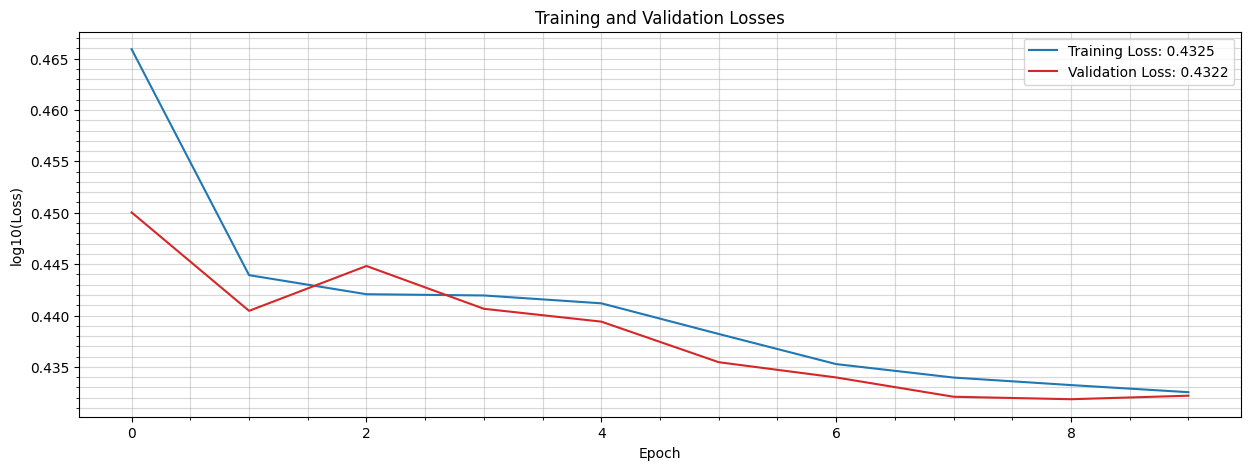

Epoch: 20/100... Training loss: 2.694358... Validation Loss: 2.694913


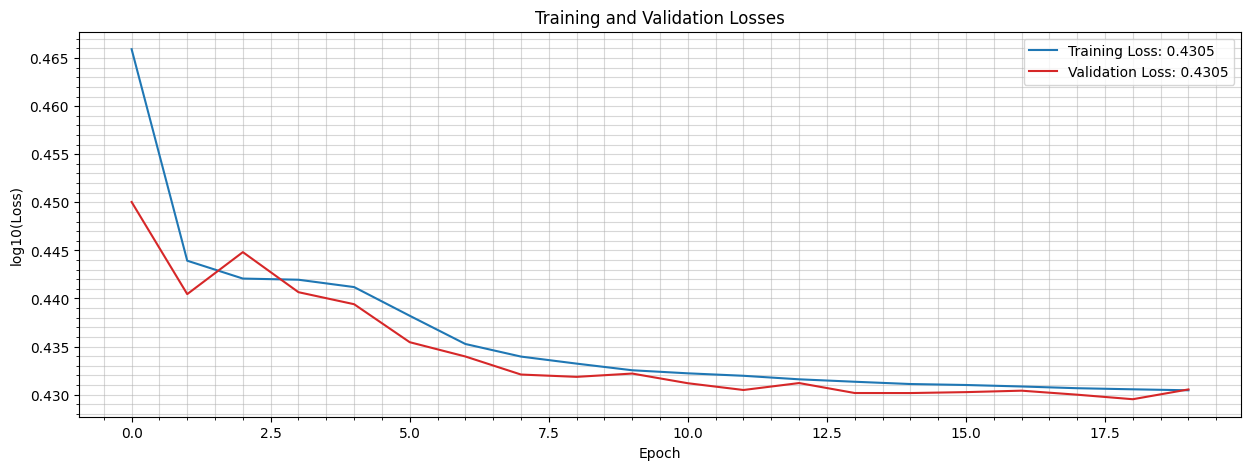

Epoch: 30/100... Training loss: 2.690265... Validation Loss: 2.691873


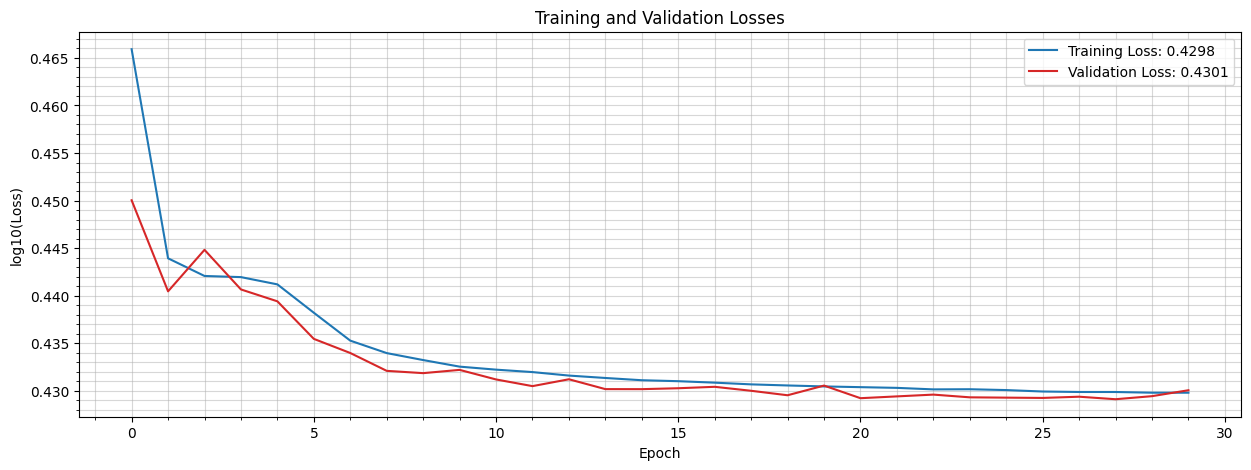

Epoch: 40/100... Training loss: 2.686947... Validation Loss: 2.690226


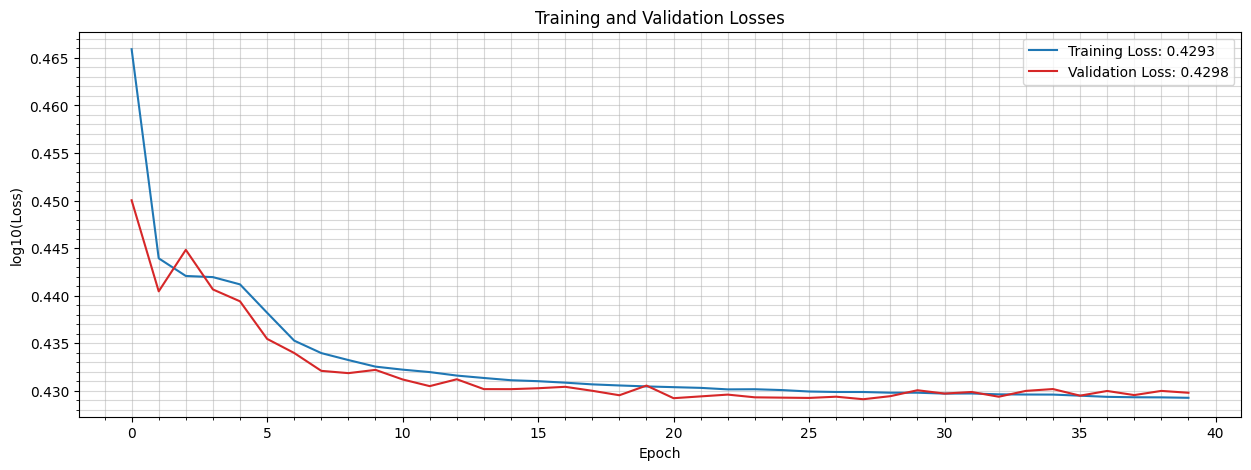

Epoch: 50/100... Training loss: 2.682824... Validation Loss: 2.695039


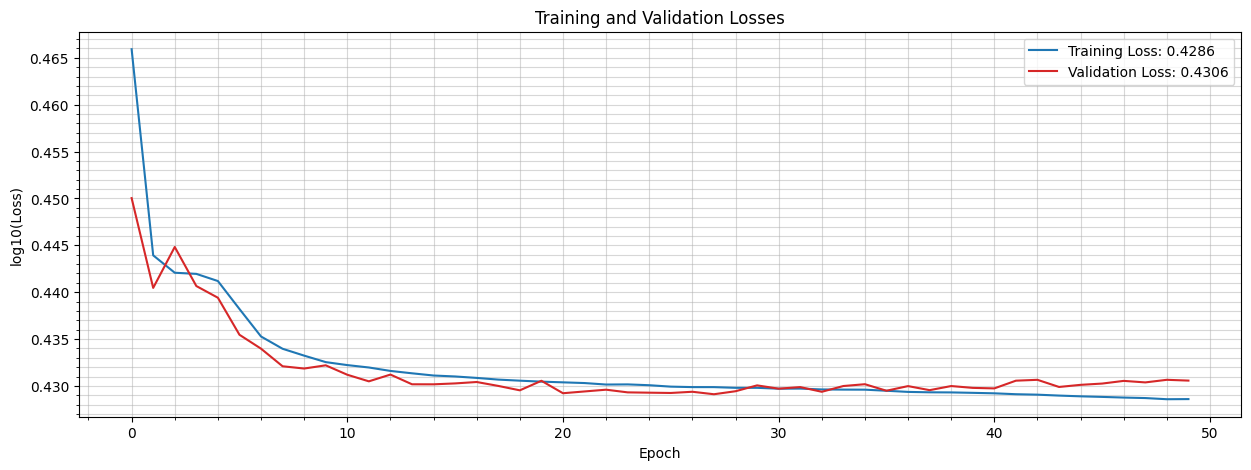

Epoch: 60/100... Training loss: 2.676597... Validation Loss: 2.701281


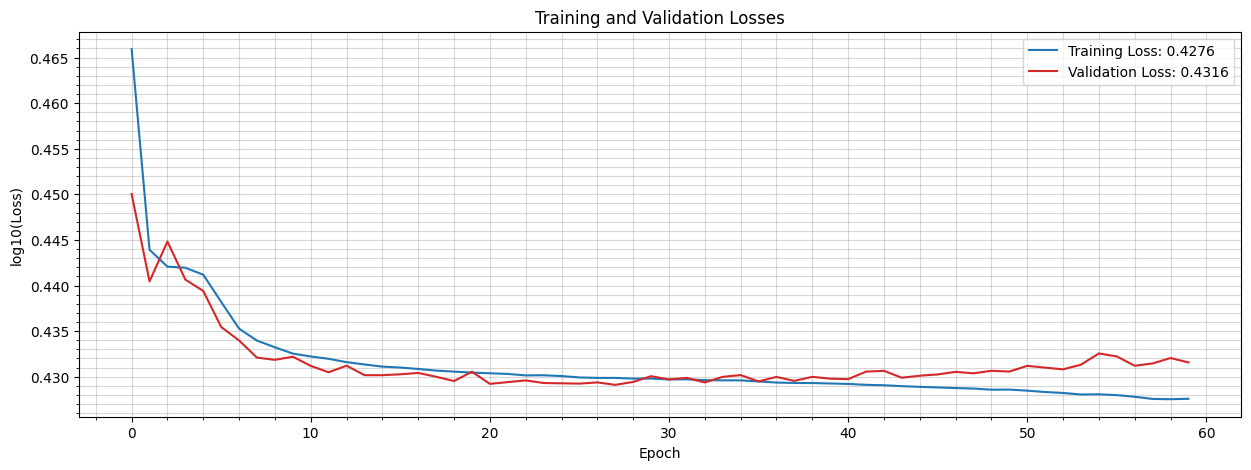

Epoch: 70/100... Training loss: 2.667444... Validation Loss: 2.711636


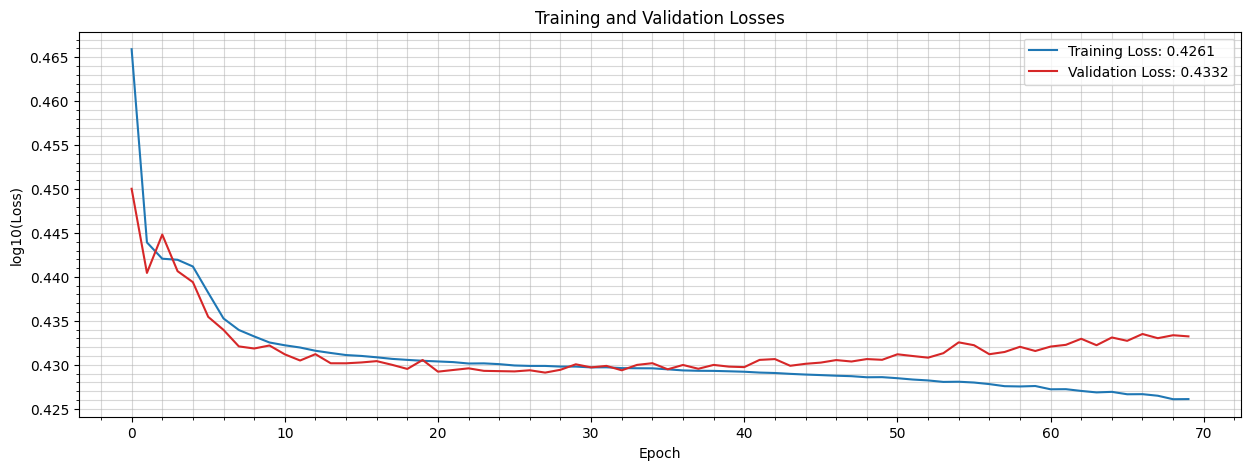

Epoch: 80/100... Training loss: 2.656559... Validation Loss: 2.719428


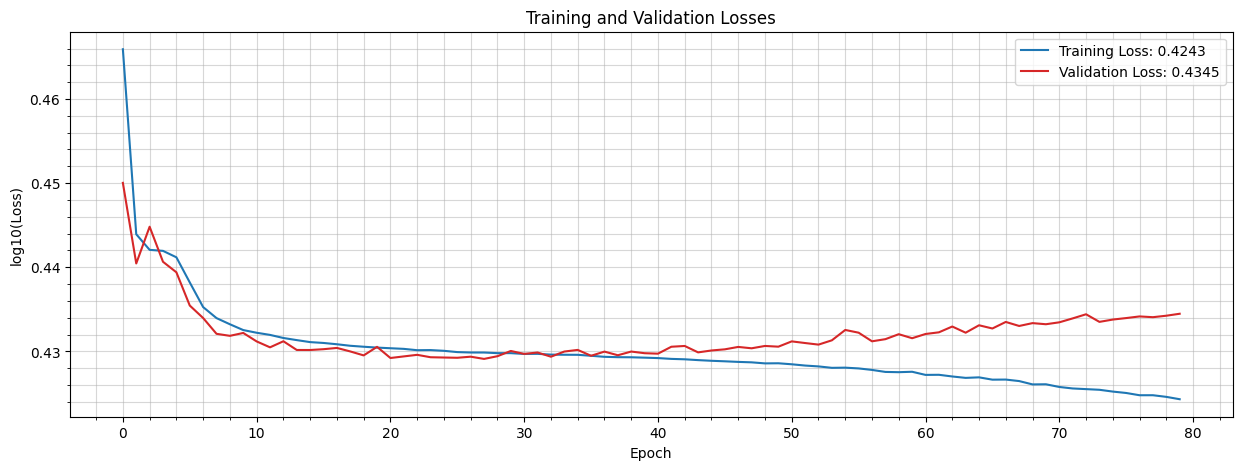

Epoch: 90/100... Training loss: 2.644324... Validation Loss: 2.731177


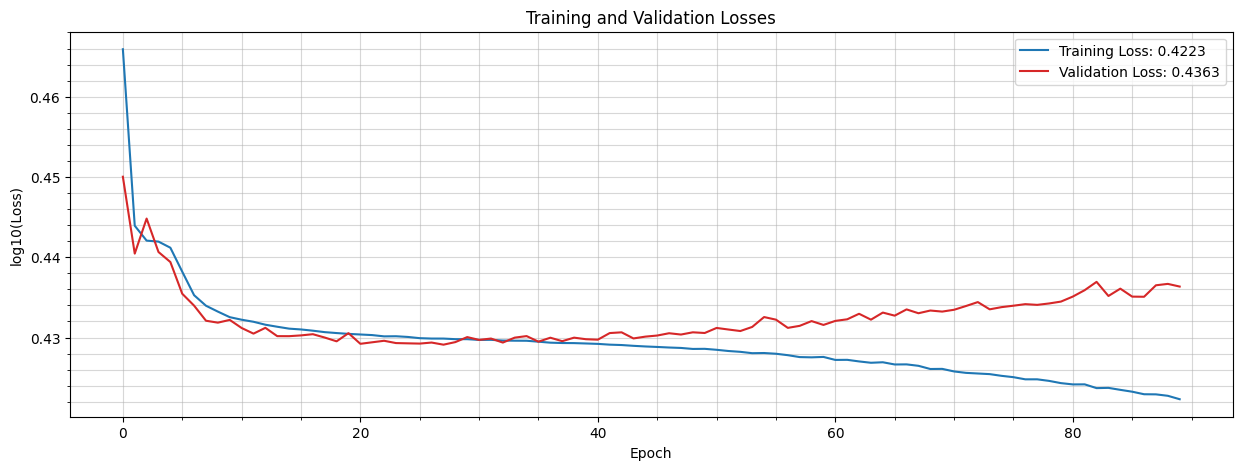

Epoch: 100/100... Training loss: 2.633929... Validation Loss: 2.743231


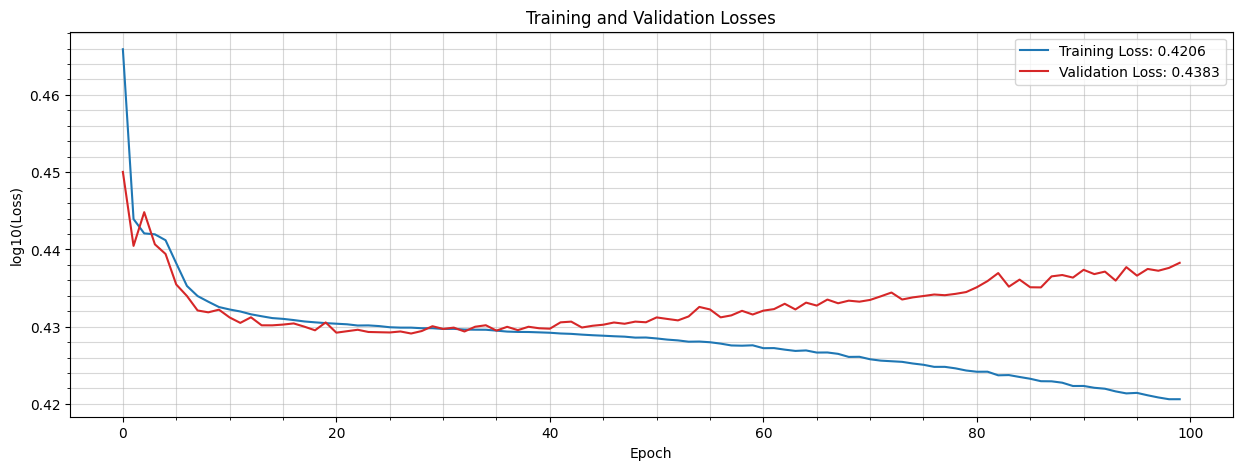

In [29]:
num_epochs = 100
val_loss_min = 1
for epoch in range(1, num_epochs + 1):

    # Training phase
    inverse_net.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()  # Reset gradients tensors
        inputs, targets = inputs.to(device), targets.to(device)

        # Forward pass through the inverse model
        inverse_outputs = inverse_net(targets)

        # Calculate loss
        loss = criterion(inverse_outputs, inputs)

        # Backward pass and optimization
        loss.backward()  # Calculate gradients
        optimizer.step()  # Update weights

        running_loss += loss.item() * inputs.size(0)  # Accumulate loss for each batch

    avg_train_loss = running_loss / len(train_loader.dataset)  # Calculate average loss over an epoch
    train_losses.append(avg_train_loss)  # Epoch training losses for plotting

    #'''
    # Validation phase
    inverse_net.eval()  # Set model to evaluation mode
    running_val_loss = 0.0
    with torch.no_grad():  # Disable gradient calculation
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            inverse_outputs = inverse_net(targets)
            val_loss = criterion(inverse_outputs, inputs)
            running_val_loss += val_loss.item() * inputs.size(0)
        avg_val_loss = running_val_loss / len(val_loader.dataset)
        val_losses.append(avg_val_loss)  # Append average validation loss for the epoch
    #'''

    # Print training progress
    if(epoch%(num_epochs//10) == 0):
        print(f"Epoch: {epoch}/{num_epochs}... Training loss: {avg_train_loss:.6f}... Validation Loss: {avg_val_loss:.6f}")
        plot_training_progress(np.log10(train_losses), np.log10(val_losses), ylabel = "log10(Loss)")
